## Interpr√©tation initiale des fichiers

Dans cette premi√®re phase, on a charg√© l'ensemble des jeux de donn√©es en d√©tectant automatiquement leur encodage afin d'√©viter les erreurs de lecture li√©es aux caract√®res sp√©ciaux. Chaque fichier a √©t√© converti en DataFrame avec le bon s√©parateur, puis on a extrait des informations cl√©s : dimensions des jeux de donn√©es, noms de colonnes, types de variables et nombre de valeurs manquantes.

Ce diagnostic permet de mieux comprendre la structure des donn√©es avant tout nettoyage ou transformation, et d'anticiper les √©tapes de traitement √† appliquer (gestion des valeurs nulles, types √† corriger, etc.).


In [333]:
import chardet
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.subplots as sp


# Dictionnaire de fichiers

files = {
    "retours": "dataset/retours V2.csv",
    "achats": "dataset/achats V2.csv",
    "fournisseurs": "dataset/fournisseurs V2.csv",
    "stocks": "dataset/stocks V2.csv",
    "expeditions": "dataset/expeditions V2.csv",
    "commandes": "dataset/commandes V2.csv",
    "produits": "dataset/produits V2.csv"
}

dfs_cleaned = {}

for name, path in files.items():
    # D√©tection de l'encodage pour chaque fichier
    with open(path, 'rb') as f:
        result = chardet.detect(f.read())
    encoding = result['encoding']
    print(f"Encodage d√©tect√© pour {name} : {encoding}")

    # Lecture du fichier avec l'encodage d√©tect√©
    dfs_cleaned[name] = pd.read_csv(path, encoding=encoding, sep=';')


# Aper√ßu des colonnes, types, valeurs manquantes, etc.
info_dict = {}
for name, df in dfs_cleaned.items():
    info_dict[name] = {
        "shape": df.shape,
        "columns": df.columns.tolist(),
        "dtypes": df.dtypes.astype(str).to_dict(),
        "missing_values": df.isnull().sum().to_dict()
    }

info_dict


Encodage d√©tect√© pour retours : UTF-8-SIG
Encodage d√©tect√© pour achats : UTF-8-SIG
Encodage d√©tect√© pour fournisseurs : UTF-8-SIG
Encodage d√©tect√© pour stocks : UTF-8-SIG
Encodage d√©tect√© pour expeditions : UTF-8-SIG
Encodage d√©tect√© pour commandes : UTF-8-SIG
Encodage d√©tect√© pour produits : UTF-8-SIG


{'retours': {'shape': (2987, 4),
  'columns': ['id_commande', 'id_produit', 'date_retour', 'motif'],
  'dtypes': {'id_commande': 'object',
   'id_produit': 'object',
   'date_retour': 'object',
   'motif': 'object'},
  'missing_values': {'id_commande': 0,
   'id_produit': 0,
   'date_retour': 0,
   'motif': 0}},
 'achats': {'shape': (10000, 7),
  'columns': ['id_achat',
   'date_achat',
   'id_produit',
   'quantite',
   'id_fournisseur',
   'prix_unitaire',
   'delai_livraison_jours'],
  'dtypes': {'id_achat': 'object',
   'date_achat': 'object',
   'id_produit': 'object',
   'quantite': 'int64',
   'id_fournisseur': 'object',
   'prix_unitaire': 'float64',
   'delai_livraison_jours': 'int64'},
  'missing_values': {'id_achat': 0,
   'date_achat': 0,
   'id_produit': 0,
   'quantite': 0,
   'id_fournisseur': 0,
   'prix_unitaire': 0,
   'delai_livraison_jours': 0}},
 'fournisseurs': {'shape': (50, 6),
  'columns': ['id_fournisseur',
   'nom_fournisseur',
   'ville',
   'pays',
   'fiab

## Normalisation des noms de colonnes et traitement des dates

Dans cette section, une premi√®re harmonisation des noms de colonnes a √©t√© r√©alis√©e : la colonne "entrep√¥t", pr√©sente dans certains fichiers, a √©t√© renomm√©e en "entrepot" pour √©viter tout probl√®me li√© aux accents, notamment lors des jointures ou des traitements ult√©rieurs.

Ensuite, une fonction g√©n√©rique a √©t√© appliqu√©e √† l‚Äôensemble des DataFrames pour convertir automatiquement toutes les colonnes contenant le mot "date" en format datetime. Cette √©tape est essentielle pour permettre des analyses temporelles fiables et pr√©cises, en assurant une coh√©rence des formats sur tous les jeux de donn√©es.


In [334]:
# Correction "entrep√¥t" ‚Üí "entrepot"
for df in dfs_cleaned.values(): # Use dfs_cleaned instead of normalized_dfs
    if "entrep√¥t" in df.columns:
        df.rename(columns={"entrep√¥t": "entrepot"}, inplace=True)

In [335]:
# Conversion des dates
def convert_dates(df):
    for col in df.columns:
        if "date" in col:
            df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
    return df

# Apply convert_dates to dfs_cleaned and store the result in normalized_dfs
normalized_dfs = {name: convert_dates(df) for name, df in dfs_cleaned.items()}

C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\2023025455.py:5: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



## Exploration descriptive des jeux de donn√©es

√Ä l'aide du package `summarytools`, nous avons g√©n√©r√© des r√©sum√©s statistiques d√©taill√©s pour chacun des jeux de donn√©es. Cette √©tape permet de visualiser rapidement :

- la structure des donn√©es (types de colonnes, nombre de lignes, etc.)
- la distribution des variables quantitatives et qualitatives
- les fr√©quences des modalit√©s
- la pr√©sence √©ventuelle de valeurs extr√™mes ou incoh√©rentes

Cette analyse exploratoire est cruciale pour identifier les probl√®mes potentiels dans les donn√©es avant de passer au nettoyage approfondi, aux fusions ou √† la mod√©lisation.


In [336]:
import summarytools as st
st.dfSummary(dfs_cleaned['retours'])

In [337]:
st.dfSummary(dfs_cleaned['achats'])

In [338]:
st.dfSummary(dfs_cleaned['fournisseurs'])

In [339]:
st.dfSummary(dfs_cleaned['stocks'])

In [340]:
st.dfSummary(dfs_cleaned['expeditions'])

In [341]:
st.dfSummary(dfs_cleaned['commandes'])

In [342]:
st.dfSummary(dfs_cleaned['produits'])

## Visualisation synth√©tique avec skimpy

Le package `skimpy` a √©t√© utilis√© pour g√©n√©rer une vue rapide et lisible des principaux indicateurs statistiques pour chaque jeu de donn√©es. Contrairement √† `summarytools`, qui est tr√®s d√©taill√©, `skimpy` offre une synth√®se plus concise, mettant l‚Äôaccent sur :

- les types de variables
- la proportion de valeurs manquantes
- les statistiques de base pour les variables num√©riques (min, max, moyenne, √©cart-type)
- les distributions pour les variables cat√©gorielles

Cette √©tape permet de rep√©rer facilement les colonnes probl√©matiques (trop de valeurs nulles, valeurs aberrantes, mauvais type, etc.) et de prioriser les traitements √† effectuer dans la suite du projet.


In [343]:
import skimpy as sk
sk.skim(dfs_cleaned['retours'])

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ skimpy summary ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ          Data Summary                Data Types                                                                 ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì                                                          ‚îÇ
‚îÇ ‚îÉ Dataframe         ‚îÉ Values ‚îÉ ‚îÉ Column Type ‚îÉ Count ‚îÉ                                                          ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î© ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©                                                          ‚îÇ
‚îÇ ‚îÇ Number of rows    ‚îÇ 2987   ‚îÇ ‚îÇ string      ‚îÇ 3     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îÇ Number of columns ‚îÇ 4      ‚îÇ ‚îÇ datetime64  ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò                                                          ‚îÇ
‚îÇ                                                    datetime                                                     ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column            ‚îÉ NA      ‚îÉ NA %                      ‚îÉ first           ‚îÉ last            ‚îÉ frequency    ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ
‚îÇ ‚îÇ date_retour       ‚îÇ    1822 ‚îÇ         60.99765651155005 ‚îÇ   2024-01-02    ‚îÇ   2025-12-01    ‚îÇ None         ‚îÇ  ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò  ‚îÇ
‚îÇ                                                     string                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ           ‚îÉ    ‚îÉ      ‚îÉ           ‚îÉ           ‚îÉ           ‚îÉ           ‚îÉ chars per ‚îÉ words per ‚îÉ total      ‚îÉ  ‚îÇ
‚îÇ ‚îÉ column    ‚îÉ NA ‚îÉ NA % ‚îÉ shortest  ‚îÉ longest   ‚îÉ min       ‚îÉ max       ‚îÉ row       ‚îÉ row       ‚îÉ words      ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ


In [344]:
sk.skim(dfs_cleaned['achats'])

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ skimpy summary ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ          Data Summary                Data Types                                                                 ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì                                                          ‚îÇ
‚îÇ ‚îÉ Dataframe         ‚îÉ Values ‚îÉ ‚îÉ Column Type ‚îÉ Count ‚îÉ                                                          ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î© ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©                                                          ‚îÇ
‚îÇ ‚îÇ Number of rows    ‚îÇ 10000  ‚îÇ ‚îÇ string      ‚îÇ 3     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îÇ Number of columns ‚îÇ 7      ‚îÇ ‚îÇ int64       ‚îÇ 2     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚îÇ datetime64  ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îÇ float64     ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò                                                          ‚îÇ
‚îÇ                                                     number                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column                  ‚îÉ NA  ‚îÉ NA %  ‚îÉ mean   ‚îÉ sd     ‚îÉ p0     ‚îÉ p25    ‚îÉ p50    ‚îÉ p75   ‚îÉ p100 ‚îÉ hist   ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ
‚îÇ ‚îÇ quantite                ‚îÇ   0 ‚îÇ     0 ‚îÇ  99.51 ‚îÇ  98.58 ‚îÇ     10 ‚îÇ     25 ‚îÇ     75 ‚îÇ   100 ‚îÇ  500 ‚îÇ  ‚ñá‚ñÉ‚ñÅ‚ñÅ  ‚îÇ  ‚îÇ
‚îÇ ‚îÇ prix_unitaire           ‚îÇ   0 ‚îÇ     0 ‚îÇ  155.2 ‚îÇ  83.66 ‚îÇ  10.03 ‚îÇ  83.09 ‚îÇ  155.4 ‚îÇ 227.7 ‚îÇ  300 ‚îÇ ‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá ‚îÇ  ‚îÇ
‚îÇ ‚îÇ delai_livraison_jours   ‚îÇ   0 ‚îÇ     0 ‚îÇ  7.956 ‚îÇ  3.754 ‚îÇ      2 ‚îÇ      5 ‚îÇ      8 ‚îÇ    11 ‚îÇ   14 ‚îÇ ‚ñÖ‚ñÜ‚ñÖ‚ñÖ‚ñÖ‚ñá ‚îÇ  ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò  ‚îÇ
‚îÇ                                                    datetime                                                     ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column               ‚îÉ

In [345]:
sk.skim(dfs_cleaned['fournisseurs'])

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ skimpy summary ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ          Data Summary                Data Types                                                                 ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì                                                          ‚îÇ
‚îÇ ‚îÉ Dataframe         ‚îÉ Values ‚îÉ ‚îÉ Column Type ‚îÉ Count ‚îÉ                                                          ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î© ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©                                                          ‚îÇ
‚îÇ ‚îÇ Number of rows    ‚îÇ 50     ‚îÇ ‚îÇ string      ‚îÇ 4     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îÇ Number of columns ‚îÇ 6      ‚îÇ ‚îÇ float64     ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚îÇ int64       ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò                                                          ‚îÇ
‚îÇ                                                     number                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column               ‚îÉ NA  ‚îÉ NA %  ‚îÉ mean    ‚îÉ sd      ‚îÉ p0   ‚îÉ p25     ‚îÉ p50   ‚îÉ p75     ‚îÉ p100  ‚îÉ hist   ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ
‚îÇ ‚îÇ fiabilite            ‚îÇ   0 ‚îÇ     0 ‚îÇ  0.7384 ‚îÇ  0.1536 ‚îÇ  0.5 ‚îÇ  0.6125 ‚îÇ  0.72 ‚îÇ  0.8775 ‚îÇ     1 ‚îÇ ‚ñá‚ñÖ‚ñÉ‚ñÇ‚ñá‚ñÉ ‚îÇ  ‚îÇ
‚îÇ ‚îÇ delai_moyen_jours    ‚îÇ   0 ‚îÇ     0 ‚îÇ    8.14 ‚îÇ   3.064 ‚îÇ    3 ‚îÇ       6 ‚îÇ   8.5 ‚îÇ      10 ‚îÇ    14 ‚îÇ ‚ñÖ‚ñÉ‚ñÖ‚ñá‚ñÉ‚ñÉ ‚îÇ  ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò  ‚îÇ
‚îÇ                                                     string                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ           ‚îÉ    ‚îÉ      ‚îÉ          ‚îÉ           ‚îÉ           ‚îÉ           ‚îÉ chars per  ‚îÉ words per ‚îÉ total      ‚îÉ  ‚îÇ
‚îÇ ‚îÉ column    ‚îÉ NA ‚îÉ NA % ‚îÉ shortest ‚îÉ longest   ‚îÉ min       ‚îÉ max       ‚îÉ row        ‚îÉ row       ‚îÉ words      ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [346]:
sk.skim(dfs_cleaned['stocks'])

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ skimpy summary ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ          Data Summary                Data Types                                                                 ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì                                                          ‚îÇ
‚îÇ ‚îÉ Dataframe         ‚îÉ Values ‚îÉ ‚îÉ Column Type ‚îÉ Count ‚îÉ                                                          ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î© ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©                                                          ‚îÇ
‚îÇ ‚îÇ Number of rows    ‚îÇ 1706   ‚îÇ ‚îÇ string      ‚îÇ 2     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îÇ Number of columns ‚îÇ 4      ‚îÇ ‚îÇ datetime64  ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚îÇ int64       ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò                                                          ‚îÇ
‚îÇ                                                     number                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column            ‚îÉ NA   ‚îÉ NA %   ‚îÉ mean     ‚îÉ sd       ‚îÉ p0   ‚îÉ p25   ‚îÉ p50     ‚îÉ p75   ‚îÉ p100  ‚îÉ hist    ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ
‚îÇ ‚îÇ niveau_stock      ‚îÇ    0 ‚îÇ      0 ‚îÇ    148.6 ‚îÇ    88.08 ‚îÇ    0 ‚îÇ    72 ‚îÇ   147.5 ‚îÇ   226 ‚îÇ   299 ‚îÇ ‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá  ‚îÇ  ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò  ‚îÇ
‚îÇ                                                    datetime                                                     ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column         ‚îÉ NA     ‚îÉ NA %       ‚îÉ first                 ‚îÉ last                  ‚îÉ frequency           ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [347]:
sk.skim(dfs_cleaned['expeditions'])

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ skimpy summary ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ          Data Summary                Data Types                                                                 ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì                                                          ‚îÇ
‚îÇ ‚îÉ Dataframe         ‚îÉ Values ‚îÉ ‚îÉ Column Type ‚îÉ Count ‚îÉ                                                          ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î© ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©                                                          ‚îÇ
‚îÇ ‚îÇ Number of rows    ‚îÇ 42404  ‚îÇ ‚îÇ string      ‚îÇ 5     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îÇ Number of columns ‚îÇ 10     ‚îÇ ‚îÇ int64       ‚îÇ 2     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚îÇ datetime64  ‚îÇ 2     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îÇ float64     ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò                                                          ‚îÇ
‚îÇ                                                     number                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column               ‚îÉ NA  ‚îÉ NA %   ‚îÉ mean    ‚îÉ sd      ‚îÉ p0  ‚îÉ p25     ‚îÉ p50   ‚îÉ p75    ‚îÉ p100  ‚îÉ hist    ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ
‚îÇ ‚îÇ quantite             ‚îÇ   0 ‚îÇ      0 ‚îÇ   4.789 ‚îÇ   4.462 ‚îÇ   1 ‚îÇ       2 ‚îÇ     3 ‚îÇ      8 ‚îÇ    20 ‚îÇ  ‚ñá‚ñÇ‚ñÇ‚ñÅ‚ñÅ  ‚îÇ  ‚îÇ
‚îÇ ‚îÇ cout_transport       ‚îÇ   0 ‚îÇ      0 ‚îÇ   14.65 ‚îÇ   3.486 ‚îÇ   6 ‚îÇ   12.22 ‚îÇ  14.4 ‚îÇ  17.09 ‚îÇ    22 ‚îÇ ‚ñÅ‚ñÖ‚ñá‚ñá‚ñÖ‚ñÉ  ‚îÇ  ‚îÇ
‚îÇ ‚îÇ delai_livraison      ‚îÇ   0 ‚îÇ      0 ‚îÇ   3.724 ‚îÇ   1.457 ‚îÇ   2 ‚îÇ    2.75 ‚îÇ     4 ‚îÇ      4 ‚îÇ     7 ‚îÇ ‚ñá‚ñÜ‚ñá‚ñÇ‚ñÉ‚ñÅ  ‚îÇ  ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò  ‚îÇ
‚îÇ                                                    datetime                                                     ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column                

In [348]:
sk.skim(dfs_cleaned['commandes'])

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ skimpy summary ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ          Data Summary                Data Types                                                                 ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì                                                          ‚îÇ
‚îÇ ‚îÉ Dataframe         ‚îÉ Values ‚îÉ ‚îÉ Column Type ‚îÉ Count ‚îÉ                                                          ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î© ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©                                                          ‚îÇ
‚îÇ ‚îÇ Number of rows    ‚îÇ 42404  ‚îÇ ‚îÇ string      ‚îÇ 4     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îÇ Number of columns ‚îÇ 6      ‚îÇ ‚îÇ datetime64  ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚îÇ int64       ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò                                                          ‚îÇ
‚îÇ                                                     number                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column        ‚îÉ NA   ‚îÉ NA %    ‚îÉ mean      ‚îÉ sd       ‚îÉ p0   ‚îÉ p25    ‚îÉ p50   ‚îÉ p75   ‚îÉ p100    ‚îÉ hist     ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ
‚îÇ ‚îÇ quantite      ‚îÇ    0 ‚îÇ       0 ‚îÇ     4.789 ‚îÇ    4.462 ‚îÇ    1 ‚îÇ      2 ‚îÇ     3 ‚îÇ     8 ‚îÇ      20 ‚îÇ  ‚ñá‚ñÇ‚ñÇ‚ñÅ‚ñÅ   ‚îÇ  ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò  ‚îÇ
‚îÇ                                                    datetime                                                     ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column              ‚îÉ NA       ‚îÉ NA %                      ‚îÉ first          ‚îÉ last           ‚îÉ frequency   ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©

In [349]:
sk.skim(dfs_cleaned['produits'])

‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ skimpy summary ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ          Data Summary                Data Types                                                                 ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì                                                          ‚îÇ
‚îÇ ‚îÉ Dataframe         ‚îÉ Values ‚îÉ ‚îÉ Column Type ‚îÉ Count ‚îÉ                                                          ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î© ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©                                                          ‚îÇ
‚îÇ ‚îÇ Number of rows    ‚îÇ 1000   ‚îÇ ‚îÇ string      ‚îÇ 3     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îÇ Number of columns ‚îÇ 5      ‚îÇ ‚îÇ float64     ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚îÇ int64       ‚îÇ 1     ‚îÇ                                                          ‚îÇ
‚îÇ                                ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò                                                          ‚îÇ
‚îÇ                                                     number                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ column           ‚îÉ NA  ‚îÉ NA %   ‚îÉ mean    ‚îÉ sd      ‚îÉ p0     ‚îÉ p25    ‚îÉ p50    ‚îÉ p75    ‚îÉ p100   ‚îÉ hist    ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©  ‚îÇ
‚îÇ ‚îÇ prix             ‚îÇ   0 ‚îÇ      0 ‚îÇ   260.1 ‚îÇ   140.5 ‚îÇ  22.22 ‚îÇ  133.1 ‚îÇ  262.1 ‚îÇ  377.6 ‚îÇ  499.7 ‚îÇ ‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá  ‚îÇ  ‚îÇ
‚îÇ ‚îÇ stock_minimum    ‚îÇ   0 ‚îÇ      0 ‚îÇ    53.4 ‚îÇ   25.58 ‚îÇ     10 ‚îÇ     31 ‚îÇ     54 ‚îÇ     75 ‚îÇ     99 ‚îÇ ‚ñá‚ñá‚ñá‚ñá‚ñá‚ñÜ  ‚îÇ  ‚îÇ
‚îÇ ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò  ‚îÇ
‚îÇ                                                     string                                                      ‚îÇ
‚îÇ ‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì  ‚îÇ
‚îÇ ‚îÉ           ‚îÉ    ‚îÉ      ‚îÉ           ‚îÉ           ‚îÉ           ‚îÉ           ‚îÉ chars per ‚îÉ words per  ‚îÉ total     ‚îÉ  ‚îÇ
‚îÇ ‚îÉ column    ‚îÉ NA ‚îÉ NA % ‚îÉ shortest  ‚îÉ longest   ‚îÉ min       ‚îÉ max       ‚îÉ row       ‚îÉ row        ‚îÉ words     ‚îÉ  ‚îÇ
‚îÇ ‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

## √âvaluation de la pertinence des jeux de donn√©es

Un ensemble de crit√®res objectifs a √©t√© d√©fini pour juger de la pertinence des datasets par rapport √† notre objectif analytique :

- Le dataset doit contenir un volume significatif (plus de 100 lignes)
- Il doit √™tre structur√© (au moins 3 colonnes)
- Il doit contenir des informations temporelles (`date`), des mesures quantitatives (`quantit√©`) ou des identifiants (`id_`) facilitant les jointures

Chaque dataset a √©t√© pass√© au crible selon ces crit√®res. Le r√©sultat a √©t√© r√©sum√© dans un tableau qui indique, pour chaque source de donn√©es, la pr√©sence ou non de ces √©l√©ments cl√©s ainsi qu‚Äôun indicateur binaire de pertinence globale.

Cela nous permet de filtrer les sources utiles pour la suite du projet (analyse, mod√©lisation, visualisation) et de mettre de c√¥t√© les donn√©es non exploitables ou trop pauvres en information.


In [350]:
# Crit√®res de pertinence :
# - Donn√©es structur√©es avec des volumes significatifs
# - Pr√©sence de dates, quantit√©s, identifiants utiles
# - Liens clairs avec d'autres datasets

dataset_pertinence = []

for name, df in dfs_cleaned.items():
    nb_rows = df.shape[0]
    nb_cols = df.shape[1]
    has_date = any('date' in col.lower() for col in df.columns)
    has_id = any('id_' in col.lower() for col in df.columns)
    has_quant = any('quant' in col.lower() for col in df.columns)

    pertinent = nb_rows > 100 and nb_cols >= 3 and (has_date or has_quant) and has_id

    dataset_pertinence.append({
        "Dataset": name,
        "Nb lignes": nb_rows,
        "Nb colonnes": nb_cols,
        "Contient dates": has_date,
        "Contient quantit√©s": has_quant,
        "Contient IDs": has_id,
        "Pertinent": pertinent
    })

pertinence_df = pd.DataFrame(dataset_pertinence)

from IPython.display import display

# Display the dataframe to the user
display(pertinence_df)

Dataset  Nb lignes  Nb colonnes  Contient dates  Contient quantit√©s  \
0       retours       2987            4            True               False   
1        achats      10000            7            True                True   
2  fournisseurs         50            6           False               False   
3        stocks       1706            4            True               False   
4   expeditions      42404           10            True                True   
5     commandes      42404            6            True                True   
6      produits       1000            5           False               False   

   Contient IDs  Pertinent  
0          True       True  
1          True       True  
2          True      False  
3          True       True  
4          True       True  
5          True       True  
6          True      False

# Mise en avant de KPI et d‚Äôindicateurs op√©rationnels

## INDICATEURS : Calcul et Visualisation

 # 1. Analyse des Produits


## Analyse crois√©e des produits : prix √©lev√© et stock minimum bas

Dans cette √©tape, l‚Äôobjectif √©tait d‚Äôidentifier les produits dits "critiques", c‚Äôest-√†-dire ceux qui pr√©sentent √† la fois :

- un prix sup√©rieur au troisi√®me quartile (Q3) ‚Üí produits chers
- un stock minimum inf√©rieur au premier quartile (Q1) ‚Üí niveau de s√©curit√© bas

Cette double condition permet de rep√©rer les produits strat√©giques ou √† risque : ils co√ªtent cher √† l‚Äôunit√©, mais sont faiblement stock√©s, ce qui pourrait engendrer des ruptures co√ªteuses ou des pertes de ventes si la demande augmente soudainement.

Parmi les 1 000 produits du dataset, plusieurs r√©pondent √† ces crit√®res, et pourraient justifier une attention particuli√®re c√¥t√© approvisionnement ou gestion des stocks.


In [351]:
# 1. Nombre total de produits
nombre_total_produits = len(dfs_cleaned['produits'])
print(f"Nombre total de produits : {nombre_total_produits}")

# Calculer le 3√®me quartile (Q3) pour les prix
q3_prix = dfs_cleaned['produits']['prix'].quantile(0.75)

# Calculer le 1er quartile (Q1) pour les stocks minimums
q1_stock_minimum = dfs_cleaned['produits']['stock_minimum'].quantile(0.25)

# Identifier les produits avec prix √©lev√© ET stock minimum bas
produits_chers_stock_min_bas = dfs_cleaned['produits'][
    (dfs_cleaned['produits']['prix'] > q3_prix) &
    (dfs_cleaned['produits']['stock_minimum'] < q1_stock_minimum)
]

print(f"\nProduits Chers (Prix > Q3={q3_prix:.2f}) avec Stock Minimum Bas (Stock Min < Q1={q1_stock_minimum:.2f}):")
if not produits_chers_stock_min_bas.empty:
    print(produits_chers_stock_min_bas[['id_produit', 'categorie', 'marque', 'prix', 'stock_minimum']])
else:
    print("Aucun produit ne correspond √† ces crit√®res.")



Nombre total de produits : 1000

Produits Chers (Prix > Q3=377.62) avec Stock Minimum Bas (Stock Min < Q1=31.00):
    id_produit          categorie                marque    prix  stock_minimum
11      P00012         Maquillage           Maison Pure  464.27             20
15      P00016            Parfums            Luxe eclat  422.67             16
40      P00041  Soins capillaires            Luxe eclat  459.13             19
51      P00052  Soins capillaires           Maison Pure  498.50             20
109     P00110         Maquillage  E¬âlixir Haute Beaut√©  448.48             12
..         ...                ...                   ...     ...            ...
904     P00905  Soins capillaires    Les Essences Rares  483.59             22
916     P00917         Maquillage        Secret de Peau  394.77             30
944     P00945         Maquillage         S√©rum de Lune  417.22             21
946     P00947            Parfums    Infusion Pr√©cieuse  389.27             20
978     P0097

## Visualisation : Prix vs Stock Minimum avec classification strat√©gique

Dans cette visualisation interactive, chaque point repr√©sente un produit, positionn√© selon :

- son **stock minimum** (axe X)
- son **prix** (axe Y)

Une classification visuelle a √©t√© appliqu√©e √† l‚Äôaide des quartiles :
- Les produits **en rouge** sont ceux consid√©r√©s comme **strat√©giques**, car √† la fois chers (prix > Q3) et faiblement stock√©s (stock_minimum < Q1).
- Les autres produits sont repr√©sent√©s en bleu clair.

Les lignes pointill√©es gris√©es repr√©sentent les seuils statistiques de r√©f√©rence (Q3 pour les prix, Q1 pour le stock minimum).

Ce graphique permet d'identifier rapidement les produits qui n√©cessitent une attention particuli√®re du point de vue de la gestion des risques ou de l'optimisation des stocks. Il peut aussi servir d‚Äôoutil d‚Äôaide √† la d√©cision pour des actions cibl√©es (r√©assort, n√©gociation fournisseurs, etc.).


In [352]:
import plotly.express as px
import plotly.graph_objects as go

df_produits = dfs_cleaned['produits'].copy()

# D√©finir les quartiles
q3_prix = df_produits['prix'].quantile(0.75)
q1_stock_minimum = df_produits['stock_minimum'].quantile(0.25)

# Cr√©er la nouvelle colonne Type de Produit
df_produits['Type de Produit'] = 'Autres Produits'
df_produits.loc[
    (df_produits['prix'] > q3_prix) & (df_produits['stock_minimum'] < q1_stock_minimum),
    'Type de Produit'
] = f'Cl√© (Prix > Q3={q3_prix:.2f}, Stock Min < Q1={q1_stock_minimum:.2f})'

# Cr√©er le scatter plot
fig = px.scatter(
    df_produits,
    x='stock_minimum',
    y='prix',
    color='Type de Produit',
    hover_data=['id_produit', 'categorie', 'marque', 'prix', 'stock_minimum'],
    title='Distribution des Produits par Prix et Stock Minimum',
    labels={'stock_minimum': 'Stock Minimum', 'prix': 'Prix du Produit'},
    color_discrete_map={
        'Autres Produits': 'lightblue',
        f'Cl√© (Prix > Q3={q3_prix:.2f}, Stock Min < Q1={q1_stock_minimum:.2f})': 'red'
    }
)

# Ajouter les lignes de r√©f√©rence (sans "name")
fig.add_shape(
    type="line",
    x0=q1_stock_minimum,
    y0=df_produits['prix'].min(),
    x1=q1_stock_minimum,
    y1=df_produits['prix'].max(),
    line=dict(color="gray", width=1, dash="dash")
)

fig.add_shape(
    type="line",
    x0=df_produits['stock_minimum'].min(),
    y0=q3_prix,
    x1=df_produits['stock_minimum'].max(),
    y1=q3_prix,
    line=dict(color="gray", width=1, dash="dash")
)

# Ajouter des annotations si tu veux qu'on voie les seuils
fig.add_annotation(
    x=q1_stock_minimum, y=df_produits['prix'].max(),
    text=f'Q1 Stock Min ({q1_stock_minimum:.2f})',
    showarrow=True, arrowhead=1, ax=-40, ay=-40
)

fig.add_annotation(
    x=df_produits['stock_minimum'].max(), y=q3_prix,
    text=f'Q3 Prix ({q3_prix:.2f})',
    showarrow=True, arrowhead=1, ax=-40, ay=40
)

fig.show()




Le nuage de points ci-dessus repr√©sente chaque produit du catalogue en fonction de son **stock minimum** (axe X) et de son **prix unitaire** (axe Y). Deux seuils statistiques ont √©t√© ajout√©s :

- **Q1 Stock Minimum (31.00)** : en dessous de ce seuil, les stocks sont consid√©r√©s comme faibles
- **Q3 Prix (377.62)** : au-dessus de ce seuil, les produits sont consid√©r√©s comme chers

Les produits en **rouge** sont ceux qui cumulent ces deux caract√©ristiques (prix √©lev√© + stock bas), et sont donc consid√©r√©s comme **strat√©giques** ou √† **surveiller en priorit√©**. Ce sont des produits √† fort impact potentiel en cas de rupture, car leur co√ªt unitaire est √©lev√© alors que leur seuil de s√©curit√© est faible.

Les autres produits sont repr√©sent√©s en **bleu clair**. Le graphique permet ainsi d‚Äôorienter rapidement les d√©cisions en mati√®re de gestion de stock, priorisation des approvisionnements ou analyse de risques.


## Analyse exploratoire des produits : cat√©gories, marques et prix

Cette section fournit un aper√ßu global du catalogue produit sous plusieurs angles :

1. **R√©partition des produits par cat√©gorie (graphique en barres)**  
   Ce graphique permet d‚Äôidentifier les familles de produits les plus repr√©sent√©es. Il met en √©vidence les cat√©gories dominantes et aide √† visualiser les d√©s√©quilibres √©ventuels dans l‚Äôoffre produit.

2. **Distribution des produits par cat√©gorie (camembert)**  
   Le diagramme circulaire compl√®te l‚Äôanalyse en montrant la part relative de chaque cat√©gorie dans l‚Äôensemble du catalogue. Il permet de visualiser la structure de l‚Äôoffre en pourcentage.

3. **Top 10 des marques les plus repr√©sent√©es**  
   Ce graphique en barres met en avant les marques les plus pr√©sentes dans l‚Äôinventaire. Cela peut r√©v√©ler une d√©pendance √† certains fournisseurs ou une concentration de l‚Äôoffre autour de marques sp√©cifiques.

4. **Distribution des prix des produits (histogramme)**  
   L‚Äôhistogramme montre la r√©partition des prix. Il permet d‚Äôidentifier la gamme de prix dominante, rep√©rer des produits tr√®s bon march√© ou tr√®s chers, et v√©rifier si les prix sont uniform√©ment r√©partis ou concentr√©s sur certaines plages.

Ces visualisations sont essentielles pour comprendre la composition de l‚Äôoffre produit avant toute analyse approfondie (rentabilit√©, performance commerciale, rotation des stocks, etc.).


In [353]:
import plotly.express as px

#1-R√©partition des produits par cat√©gorie (bar plot)
produits_par_categorie = dfs_cleaned['produits']['categorie'].value_counts().reset_index()
produits_par_categorie.columns = ['categorie', 'nombre_produits']

fig_produits_par_categorie = px.bar(
    produits_par_categorie,
    x='categorie',
    y='nombre_produits',
    title="R√©partition des produits par categorie ",
    labels={'cat√©gorie': 'Cat√©gorie', 'nombre_produits': 'Nombre de produits'},
    text='nombre_produits',
    template="plotly_white",
    color_discrete_sequence=["#818CF8"]
)
fig_produits_par_categorie.update_traces(textposition='outside')
fig_produits_par_categorie.update_layout(xaxis_tickangle=45)
fig_produits_par_categorie.show()







Le graphique met en √©vidence une r√©partition relativement √©quilibr√©e entre les diff√©rentes cat√©gories de produits :

- **Soins de la peau**, **Soins capillaires** et **Accessoires** sont les cat√©gories les plus fournies, avec un peu plus de 200 r√©f√©rences chacune.
- **Maquillage** et **Parfums** ferment la marche, mais restent proches en volume, autour de 190 produits.

Cette distribution montre que le catalogue est bien diversifi√©, sans domination √©crasante d'une seule cat√©gorie. Cela refl√®te probablement une volont√© de couvrir un large spectre de besoins clients, tout en assurant une offre √©quilibr√©e entre hygi√®ne, esth√©tique et bien-√™tre.


In [354]:
# 2-Distribution des produits par cat√©gorie (camembert)
product_distribution = dfs_cleaned['produits']['categorie'].value_counts().reset_index()
product_distribution.columns = ['categorie', 'nombre_produits']

fig = px.pie(
    product_distribution,
    names='categorie',
    values='nombre_produits',
    title="Distribution des produits par cat√©gorie",
    hole=0.5,
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(textinfo='percent+label')
fig.show()







Le diagramme circulaire permet de visualiser la **part relative de chaque cat√©gorie** dans l‚Äôensemble du catalogue produit :

- **Soins de la peau** est la cat√©gorie la plus repr√©sent√©e avec environ 21 % des r√©f√©rences.
- **Soins capillaires** et **Accessoires** suivent de tr√®s pr√®s, aux alentours de 20 %.
- **Maquillage** et **Parfums** repr√©sentent chacune environ 19 % du catalogue.

Cette r√©partition √©quilibr√©e montre une **offre produits bien r√©partie entre les grandes familles**, ce qui peut √™tre un indicateur de diversification strat√©gique. Aucun segment ne domine largement, ce qui permet de limiter les risques de d√©pendance √† un seul type de produit.


In [355]:
# 3-Top 10 Marques par nombre de produits
product_by_brand = dfs_cleaned['produits']['marque'].value_counts().reset_index()
product_by_brand.columns = ['marque', 'nombre_produits']

fig_brand = px.bar(
    product_by_brand.head(10),
    x='marque',
    y='nombre_produits',
    title="Top 10 Marques par Nombre de Produits",
    labels={'marque': 'Marque', 'nombre_produits': 'Nombre de Produits'},
    template="plotly_white"
)
fig_brand.show()





Le graphique ci-dessus montre la r√©partition des 10 marques les plus pr√©sentes dans le catalogue en fonction du **nombre de r√©f√©rences produits**.

On observe que 5 marques ("Luxe √©clat", "Maison Pure", "Essentielle Paris", "Reflet d‚Äôor", "Elixir Haute Beaut√©") dominent largement avec **100 produits chacune**. En comparaison, les 5 autres marques du classement plafonnent √† seulement **20 produits**, soit 5 fois moins.

Cette distribution sugg√®re une **forte d√©pendance √† un petit groupe de marques**, ce qui peut avoir plusieurs implications :
- Une relation commerciale strat√©gique ou privil√©gi√©e avec certains fournisseurs
- Un risque de concentration si une de ces marques devient indisponible ou change ses conditions
- Une opportunit√© de diversification en valorisant davantage les marques moins repr√©sent√©es




In [356]:
# 4-Distribution des prix des produits (histogramme)
fig_price = px.histogram(
    dfs_cleaned['produits'],
    x='prix',
    nbins=50,
    title="Distribution des Prix des Produits",
    labels={'prix': 'Prix'},
    template="plotly_white",
    color_discrete_sequence=["#D985C7"]  # Orange intense, pro et lisible
)

fig_price.update_layout(
    xaxis_title="Prix (‚Ç¨)",
    yaxis_title="Nombre de Produits"
)

fig_price.show()




Le graphique ci-dessus montre la **r√©partition des prix** des produits du catalogue. On observe une r√©partition relativement **uniforme** sur toute la plage tarifaire, allant d‚Äôenviron **30 ‚Ç¨ √† 500 ‚Ç¨**.

Quelques pics plus marqu√©s apparaissent sur certaines tranches, indiquant des regroupements strat√©giques ou des segments de prix plus populaires :

- Cela peut correspondre √† des **effets de gamme** (produits d‚Äôentr√©e, milieu ou haut de gamme)
- Ou √† une **strat√©gie marketing tarifaire** avec des prix psychologiques (ex. : 99‚Ç¨, 249‚Ç¨, 499‚Ç¨)

L‚Äôabsence de forte concentration dans une seule zone sugg√®re que l‚Äôentreprise vise **diff√©rents segments de clients**. Ce type de visualisation est utile pour √©valuer :
- La coh√©rence du positionnement prix
- Les √©ventuelles lacunes tarifaires (zones peu ou pas couvertes)
- Les opportunit√©s d‚Äôoptimisation de gamme ou de marges




In [357]:
# Calcul du 3√®me quartile (Q3) pour les prix
q3_prix = dfs_cleaned['produits']['prix'].quantile(0.75)
print(q3_prix)

# Identification des produits avec prix √©lev√© ET stock actuel inf√©rieur au stock minimum
if 'stock_actuel' in dfs_cleaned['produits'].columns:
    produits_cles_critiques = dfs_cleaned['produits'][
        (dfs_cleaned['produits']['prix'] > q3_prix) &
        (dfs_cleaned['produits']['stock_actuel'] < dfs_cleaned['produits']['stock_minimum'])
    ]

    print(f"\nProduits Cl√©s (Prix > Q3={q3_prix:.2f}) avec Stock Actuel < Stock Minimum:")
    if not produits_cles_critiques.empty:
        print(produits_cles_critiques[['id_produit', 'nom_produit', 'categorie', 'marque', 'prix', 'stock_actuel', 'stock_minimum']])
    else:
        print("Aucun produit ne correspond √† ces crit√®res actuellement.")

else:
    print("\nLa colonne 'stock_actuel' n'est pas disponible dans le DataFrame 'produits'.")
    print("Impossible d'identifier les produits cl√©s critiques bas√©s sur le stock r√©el.")
    print("Vous pourriez identifier les produits chers avec un stock minimum bas, mais l'interpr√©tation serait diff√©rente.")



377.6175

La colonne 'stock_actuel' n'est pas disponible dans le DataFrame 'produits'.
Impossible d'identifier les produits cl√©s critiques bas√©s sur le stock r√©el.
Vous pourriez identifier les produits chers avec un stock minimum bas, mais l'interpr√©tation serait diff√©rente.


## Produits avec un stock minimum sup√©rieur au prix unitaire

L‚Äôanalyse ci-dessus met en √©vidence une anomalie potentielle : certains produits pr√©sentent un **stock minimum sup√©rieur √† leur prix unitaire**. Autrement dit, on est pr√™t √† maintenir un niveau de stock relativement √©lev√© pour des produits peu co√ªteux.

Plusieurs explications possibles :
- Une politique de stock de s√©curit√© trop conservatrice
- Des erreurs de saisie dans les donn√©es
- Des produits √† forte rotation justifiant un stock minimum √©lev√© malgr√© leur faible valeur

Le graphique permet de visualiser ces produits individuellement. Il peut √™tre pertinent de croiser cette analyse avec les volumes de ventes r√©els pour v√©rifier si ces niveaux de stock sont justifi√©s ou s‚Äôil faut r√©ajuster la politique de stockage.


In [358]:
# 6. Produits sous le seuil de stock
produits_sous_seuil = dfs_cleaned['produits'][dfs_cleaned['produits']['stock_minimum'] > dfs_cleaned['produits']['prix']]
nombre_produits_sous_seuil = len(produits_sous_seuil)
print(f"Nombre de produits sous le seuil de stock : {nombre_produits_sous_seuil}")

fig_produits_sous_seuil = px.bar(
    produits_sous_seuil,
    x='id_produit',
    y='stock_minimum',
    title="Produits sous le seuil de stock",
    labels={'id_produit': 'ID Produit', 'stock_minimum': 'Stock Minimum'},
    template="plotly_white",
    color_discrete_sequence=["#A3C4F3"]  # Rose pastel soutenu
)

fig_produits_sous_seuil.update_traces(
    marker_line_color='white',
    marker_line_width=1.2
)
fig_produits_sous_seuil.update_layout(
    xaxis_tickangle=45
)
fig_produits_sous_seuil.show()


Nombre de produits sous le seuil de stock : 69




Dans cet extrait, nous avons identifi√© **69 produits** dont le **stock minimum est sup√©rieur √† leur prix unitaire**. Cela peut para√Ætre contre-intuitif, car on maintient un niveau de stock de s√©curit√© √©lev√© pour des articles √† faible valeur.

Ce genre de situation peut refl√©ter :
- Une **politique de surstockage** volontaire pour des produits √† forte rotation
- Une **mauvaise configuration** ou une erreur dans la d√©finition des seuils de stock
- Un **manque d'alignement** entre la valeur produit et sa criticit√© r√©elle

Le graphique permet de visualiser pr√©cis√©ment quels produits sont concern√©s. Une analyse plus pouss√©e, croisant cette information avec les **ventes r√©elles**, pourrait aider √† d√©cider si ces niveaux de stock sont pertinents ou doivent √™tre optimis√©s.


In [359]:
# 7. Produits √† forte valeur
produits_cher = dfs_cleaned['produits'].sort_values(by='prix', ascending=False).head(10)
fig_produits_cher = px.bar(
    produits_cher,
    x='id_produit',
    y='prix',
    title="Top 10 des produits les plus chers",
    labels={'id_produit': 'ID Produit', 'prix': 'Prix (‚Ç¨)'},
    template="plotly_white"
)
fig_produits_cher.show()



Le graphique pr√©sente les 10 produits les plus chers du catalogue. On observe une homog√©n√©it√© des prix, tous proches de 500 ‚Ç¨, ce qui peut indiquer l'existence d'un segment haut de gamme ou premium.

Ces produits repr√©sentent une forte valeur d‚Äôunit√©, ce qui les rend particuli√®rement sensibles en termes de :

- **Co√ªt d‚Äôacquisition** ou de production
- **Marge potentielle**
- **Risque de surstockage ou de rupture**

Ce type d‚Äôarticle peut n√©cessiter une **strat√©gie de gestion d√©di√©e**, avec un suivi plus fin de la demande, du stock, des retours et du positionnement concurrentiel. Il serait pertinent de croiser ces donn√©es avec les volumes de commandes ou les retours pour √©valuer leur **performance √©conomique r√©elle**.


In [360]:
# 8. Produits strat√©giques (croisement avec retours et ventes)
produits_strategiques = dfs_cleaned['retours']['id_produit'].value_counts().reset_index()
produits_strategiques.columns = ['id_produit', 'nombre_retours']
produits_strategiques = produits_strategiques.merge(
    dfs_cleaned['produits'][['id_produit', 'categorie', 'prix']],
    left_on='id_produit',
    right_on='id_produit',
    how='left'
)

fig_produits_strategiques = px.scatter(
    produits_strategiques,
    x='prix',
    y='nombre_retours',
    color='categorie',
    size='nombre_retours',
    title="Produits strat√©giques : Croisement avec retours",
    labels={'prix': 'Prix (‚Ç¨)', 'nombre_retours': 'Nombre de retours', 'cat√É¬©gorie': 'Cat√©gorie'},
    template="plotly_white"
)
fig_produits_strategiques.show()



Ce graphique en bulles met en relation deux dimensions critiques :
- Le **prix unitaire** du produit (axe X)
- Le **nombre de retours** observ√©s (axe Y)

Chaque bulle repr√©sente un produit, sa **taille** indique le volume de retours, et sa **couleur** la cat√©gorie √† laquelle il appartient.

**Ce qu‚Äôon observe :**
- Des produits √† **prix √©lev√© avec un nombre de retours important** existent dans toutes les cat√©gories : ce sont des signaux d‚Äôalerte pour la rentabilit√© (fort co√ªt + instabilit√© de satisfaction).
- Certaines bulles tr√®s visibles en haut du graphe (> 25 retours) sugg√®rent des **probl√®mes r√©currents** sur certains articles sp√©cifiques (qualit√©, attente non satisfaite...).
- Les retours sont r√©partis sur toutes les gammes de prix, mais les **produits chers mal not√©s ou souvent retourn√©s** doivent faire l‚Äôobjet d‚Äôune **analyse qualit√© ou logistique approfondie**.

Cette visualisation est essentielle pour identifier les **produits √† fort enjeu** : ils co√ªtent cher, g√©n√®rent du m√©contentement client, et peuvent d√©t√©riorer l‚Äôimage de la marque.


# 2. Analyse des Commandes

In [361]:
volume_total_commandes = dfs_cleaned['commandes']['id_commande'].nunique()
print(f"Volume total de commandes : {volume_total_commandes}")

Volume total de commandes : 42404




Le dataset contient un total de **42 404 commandes uniques** enregistr√©es. Ce volume √©lev√© indique :

- Une **activit√© commerciale soutenue**, avec un nombre cons√©quent d‚Äôop√©rations trait√©es
- Une **base statistique solide** pour r√©aliser des analyses fiables (tendances, saisonnalit√©, comportements clients)
- Une opportunit√© d'explorer des indicateurs cl√©s comme la fr√©quence des commandes, le panier moyen, ou encore le taux de transformation par produit

Ce volume justifie pleinement une segmentation plus fine (par p√©riode, par canal, par cat√©gorie de produit...) pour en extraire des insights exploitables sur les performances commerciales et logistiques.


In [362]:
# D√©lai moyen de traitement de commande
dfs_cleaned['commandes']['date_livraison'] = pd.to_datetime(dfs_cleaned['expeditions']['date_livraison'], errors='coerce')
dfs_cleaned['commandes']['delai_traitement'] = (dfs_cleaned['commandes']['date_livraison'] - dfs_cleaned['commandes']['date_commande']).dt.days
delai_moyen_traitement = dfs_cleaned['commandes']['delai_traitement'].mean()
print(f"D√©lai moyen de traitement de commande : {delai_moyen_traitement:.2f} jours")

D√©lai moyen de traitement de commande : 47.72 jours




Le d√©lai moyen entre la date de commande et la date de livraison est estim√© √† **47,72 jours**. Ce d√©lai inclut potentiellement toutes les √©tapes suivantes : pr√©paration, exp√©dition, acheminement et r√©ception.

Un tel d√©lai peut √™tre interpr√©t√© de plusieurs fa√ßons :
- Si l‚Äôactivit√© concerne des **produits sur commande ou personnalis√©s**, ce d√©lai peut √™tre acceptable.
- En revanche, pour des produits standards ou disponibles en stock, un d√©lai sup√©rieur √† 45 jours peut r√©v√©ler :
  - des **probl√®mes logistiques** (retards, ruptures, goulots d‚Äô√©tranglement)
  - un **manque de r√©activit√©** dans la cha√Æne de traitement
  - ou une **externalisation** (fournisseurs tiers, d√©lais de fabrication...)




In [363]:
# Taux de commandes annul√©es
taux_commandes_annulees = (dfs_cleaned['commandes'][dfs_cleaned['commandes']['statut'] == 'annul√©'].shape[0] / len(dfs_cleaned['commandes'])) * 100
print(f"Taux de commandes annul√©es : {taux_commandes_annulees:.2f}%")

Taux de commandes annul√©es : 0.00%


**Taux de commandes annul√©es**

Le taux de commandes annul√©es est de **0,00 %** sur l‚Äôensemble du dataset.

Ce r√©sultat peut √™tre interpr√©t√© de deux fa√ßons :

- **Hypoth√®se optimiste** : le processus de commande est parfaitement ma√Ætris√©, avec une bonne qualit√© de service, peu d‚Äôerreurs ou d‚Äôabandons c√¥t√© client. Cela refl√®terait une **satisfaction √©lev√©e** et une **logistique bien huil√©e**.




In [364]:
# Taux de commande par produit
commandes_par_produit = dfs_cleaned['commandes']['id_produit'].value_counts(normalize=True).reset_index()
commandes_par_produit.columns = ['id_produit', 'taux_commandes']
fig_taux_commandes = px.bar(commandes_par_produit.head(10),
                            x='id_produit',
                            y='taux_commandes',
                            title="Taux de commande par produit",
                            labels={'id_produit': 'ID Produit', 'taux_commandes': 'Taux de Commandes'},
                            template="plotly_white",
                            color_discrete_sequence=["#17becf"])
fig_taux_commandes.show()



Ce graphique pr√©sente les 10 produits ayant les **taux de commande les plus √©lev√©s**, c‚Äôest-√†-dire ceux qui sont revenus le plus souvent dans les commandes, rapport√© au volume total de commandes.

Quelques observations cl√©s :
- Le produit **P00620** se d√©tache avec un taux l√©g√®rement sup√©rieur √† **0,5 %**, ce qui en fait un article phare du catalogue.
- Les autres produits du top affichent √©galement un taux compris entre **0,45 % et 0,5 %**, ce qui reste significatif compte tenu du volume total (plus de 42 000 commandes).

Ces produits constituent des **leviers commerciaux majeurs**. Ils m√©ritent un suivi renforc√© en mati√®re de :
- disponibilit√© en stock,
- performance logistique (d√©lai, rupture),
- rentabilit√© (co√ªt vs prix de vente),
- et satisfaction client (retours, avis).

Ce type d‚Äôanalyse est √©galement utile pour alimenter une strat√©gie de **pr√©vision de la demande** ou d‚Äô**optimisation des assortiments**.


## √âvolution du volume de commandes dans le temps

Cette analyse pr√©sente l‚Äô√©volution du nombre de commandes sur diff√©rentes √©chelles temporelles : **jour, semaine, mois, ann√©e**.

- **Par jour** : permet de visualiser les pics d‚Äôactivit√© tr√®s pr√©cis, utile pour d√©tecter les jours de promotion, les p√©riodes de forte demande ou les anomalies.
- **Par semaine** : lisse les variations quotidiennes pour faire ressortir des tendances hebdomadaires.
- **Par mois** : donne une vue macro, utile pour observer la saisonnalit√© ou les campagnes marketing r√©currentes.
- **Par ann√©e** : parfait pour analyser la croissance de l‚Äôactivit√© ou l‚Äôimpact d‚Äô√©v√©nements exceptionnels (crise, lancement produit...).

Gr√¢ce √† ces graphiques, on peut :
- Identifier les **p√©riodes creuses ou fortes**
- D√©tecter des **saisonnalit√©s r√©currentes**
- Poser les bases d‚Äôun **mod√®le de pr√©vision de la demande**

Pour aller plus loin, il serait int√©ressant de croiser cette analyse avec :
- les **cat√©gories de produits**
- les **sources de trafic ou canaux de vente**
- les **volumes de retours** ou **incidents logistiques**


In [365]:
# Copier le DataFrame des commandes
df_commandes = dfs_cleaned['commandes'].copy()

# Extraire diff√©rentes granularit√©s de date
df_commandes['jour'] = df_commandes['date_commande'].dt.to_period('D')
df_commandes['semaine'] = df_commandes['date_commande'].dt.to_period('W')
df_commandes['mois'] = df_commandes['date_commande'].dt.to_period('M')
df_commandes['annee'] = df_commandes['date_commande'].dt.to_period('Y')

# Calculer le nombre de commandes uniques par p√©riode
commandes_by_day = df_commandes.groupby('jour')['id_commande'].nunique().reset_index(name='nombre_commandes')
commandes_by_week = df_commandes.groupby('semaine')['id_commande'].nunique().reset_index(name='nombre_commandes')
commandes_by_month = df_commandes.groupby('mois')['id_commande'].nunique().reset_index(name='nombre_commandes')
commandes_by_year = df_commandes.groupby('annee')['id_commande'].nunique().reset_index(name='nombre_commandes')

# Convertir les p√©riodes en cha√Ænes pour l'affichage sur l'axe X
commandes_by_day['jour'] = commandes_by_day['jour'].astype(str)
commandes_by_week['semaine'] = commandes_by_week['semaine'].astype(str)
commandes_by_month['mois'] = commandes_by_month['mois'].astype(str)
commandes_by_year['annee'] = commandes_by_year['annee'].astype(str)


# Palettes plus dynamiques (1 couleur dominante par graphe)
color_day   = ["#69B7D1"]  # Bleu pastel satur√©
color_week  = ["#F4A261"]  # Orange abricot profond
color_month = ["#90BE6D"]  # Vert tendre mais dense
color_year  = ["#D985C7"]  # Lavande ros√© vibrant




# Graphique par Jour
if len(commandes_by_day) > 150:
    print("Affichage du graphique par jour omis car la p√©riode est trop longue pour un bar chart lisible.")
    print(f"Nombre de jours uniques : {len(commandes_by_day)}")
    fig_day = px.line(commandes_by_day, x='jour', y='nombre_commandes',
                      title="Volume de Commandes par Jour",
                      template="plotly_white")
    fig_day.show()
else:
    fig_day = px.bar(commandes_by_day, x='jour', y='nombre_commandes',
                     title="Volume de Commandes par Jour",
                     labels={'jour': 'Jour', 'nombre_commandes': 'Nombre de commandes'},
                     text='nombre_commandes',
                     color_discrete_sequence=color_day)
    fig_day.update_layout(xaxis=dict(tickangle=45), template="plotly_white")
    fig_day.show()

# Graphique par Semaine
fig_week = px.bar(commandes_by_week, x='semaine', y='nombre_commandes',
                  title="Volume de Commandes par Semaine",
                  labels={'semaine': 'Semaine', 'nombre_commandes': 'Nombre de commandes'},
                  text='nombre_commandes',
                  color_discrete_sequence=color_week)
fig_week.update_layout(xaxis=dict(tickangle=45), template="plotly_white")
fig_week.show()

# Graphique par Mois
fig_month = px.bar(commandes_by_month, x='mois', y='nombre_commandes',
                   title="Volume de Commandes par Mois",
                   labels={'mois': 'Mois', 'nombre_commandes': 'Nombre de commandes'},
                   text='nombre_commandes',
                   color_discrete_sequence=color_month)
fig_month.update_layout(xaxis=dict(tickangle=45), template="plotly_white")
fig_month.show()

# Graphique par Ann√©e
fig_year = px.bar(commandes_by_year, x='annee', y='nombre_commandes',
                  title="Volume de Commandes par Ann√©e",
                  labels={'annee': 'Ann√©e', 'nombre_commandes': 'Nombre de commandes'},
                  text='nombre_commandes',
                  color_discrete_sequence=color_year)
fig_year.update_layout(template="plotly_white")
fig_year.show()


## R√©partition des commandes par entrep√¥t

Le graphique met en √©vidence le **nombre de commandes trait√©es par chaque entrep√¥t**. Cela permet d‚Äô√©valuer la **charge de travail logistique** r√©partie sur le r√©seau de distribution.

Quelques int√©r√™ts de cette visualisation :
- Identifier les **entrep√¥ts les plus sollicit√©s**, donc critiques pour la cha√Æne d‚Äôapprovisionnement
- D√©tecter d‚Äô√©ventuels d√©s√©quilibres (ex. : surcharge sur un site, sous-utilisation d‚Äôun autre)
- Servir de base pour une **optimisation du dispatch** ou un **r√©√©quilibrage g√©ographique**

Cette r√©partition peut aussi √™tre corr√©l√©e avec :
- les **d√©lais moyens de traitement**,
- les **taux de retour**,
- ou la **satisfaction client** pour rep√©rer les zones √† am√©liorer.



In [366]:


# R√©partition des commandes par entrep√¥t
df_commandes = normalized_dfs["commandes"]
commandes_entrepot = df_commandes['entrepot'].value_counts().reset_index()
commandes_entrepot.columns = ['entrepot', 'nombre_commandes']

fig1 = px.bar(
    commandes_entrepot,
    x='entrepot',
    y='nombre_commandes',
    text='nombre_commandes',
    color='entrepot',
    labels={'entrepot': 'Entrep√¥t', 'nombre_commandes': 'Nombre de commandes'},
    title="Nombre de commandes par entrep√¥t",
    template="plotly_white",
    color_discrete_sequence=[
        "#AEC6CF",  # Bleu pastel
        "#FFB347",  # Orange pastel
        "#CBAACB",  # Lavande pastel
        "#BFD8B8",  # Vert tendre
        "#FFDAB9",  # P√™che clair
        "#E6E6FA"   # Lilas tr√®s clair
    ]
)

fig1.update_traces(textposition='outside')
fig1.show()




Le graphique montre que les **trois entrep√¥ts principaux (Paris, Lyon, Marseille)** traitent un volume de commandes presque √©quivalent :

- **Paris** : 14 230 commandes
- **Lyon** : 14 169 commandes
- **Marseille** : 14 005 commandes

Cette r√©partition homog√®ne est un **indicateur positif de r√©partition logistique** :
- Elle permet de **lisser la charge de travail** et d‚Äô√©viter la saturation d‚Äôun seul site
- Elle offre une **meilleure couverture g√©ographique**, ce qui peut r√©duire les d√©lais de livraison
- Elle limite les risques op√©rationnels en **distribuant les d√©pendances**




------



## Top 10 des produits les plus command√©s

Ce graphique pr√©sente les **10 produits ayant √©t√© command√©s le plus souvent**, tous confondus. Ces produits repr√©sentent la **demande la plus forte** dans le catalogue et doivent faire l‚Äôobjet d‚Äôun suivi rigoureux.

Ce que cela implique :
- Ce sont des **best-sellers** √† prioriser en termes de **disponibilit√©**, de **stock de s√©curit√©** et de **r√©approvisionnement**.
- Ils peuvent √©galement servir de **r√©f√©rence pour des promotions crois√©es** ou des campagnes marketing.
- Une analyse compl√©mentaire de leur **rentabilit√©** (marge, retours, co√ªt de stockage) est recommand√©e pour √©valuer leur **valeur r√©elle** au-del√† de leur volume de commandes.

Ces produits sont des **indicateurs-cl√©s de la performance commerciale** globale, et leur suivi doit √™tre prioritaire.


In [367]:
# Top 10 des produits les plus command√©s
top_produits = df_commandes["id_produit"].value_counts().head(10).reset_index()
top_produits.columns = ["id_produit", "nb_commandes"]  # Rename columns

fig3 = px.bar(top_produits, x="id_produit", y="nb_commandes",
              color_discrete_sequence=["orange"],
              title="Top 10 des produits les plus command√©s")


fig3.show()




Le graphique ci-dessus met en lumi√®re les produits ayant g√©n√©r√© le plus de commandes. Le produit **P00620** domine ce classement avec plus de **220 commandes**, suivi de pr√®s par plusieurs autres r√©f√©rences dont **P00981** et **P00370**, qui se situent toutes autour de 200.

Ce type d'analyse est crucial pour :
- **Identifier les produits strat√©giques** du portefeuille
- S'assurer de leur **disponibilit√© permanente en stock**
- **Prioriser leur r√©approvisionnement**
- Mieux **orienter les campagnes marketing** et offres commerciales

√Ä ce stade, il serait int√©ressant de croiser ce top avec :
- Leur **valeur totale vendue** (prix x nb de commandes)
- Leur **taux de retour** ou


-------

## √âvolution du chiffre d'affaires mensuel

Ce graphique montre l‚Äô√©volution du **chiffre d‚Äôaffaires total par mois**, calcul√© en multipliant le **prix unitaire** des produits par la **quantit√© command√©e**.

Ce qu‚Äôon peut en tirer :
- On visualise clairement les **pics de ventes** ainsi que les p√©riodes de creux
- Cela permet d‚Äôidentifier des **saisonnalit√©s**, des **effets de campagne** ou des **lancements produits**
- C‚Äôest un excellent indicateur pour √©valuer l'**impact des actions commerciales ou logistiques**

En analysant ce graphe, l‚Äôentreprise peut :
- Adapter sa **pr√©vision de la demande**
- Optimiser ses **stocks** et ses **capacit√©s logistiques**
- Calibrer ses **campagnes marketing** en fonction des p√©riodes √† fort ou faible potentiel

Pour aller plus loin, on pourrait croiser ce chiffre d‚Äôaffaires :
- Par **cat√©gorie** ou **marque**
- Par **canal de vente** (si disponible)
- Ou comparer **CA vs. volume** pour d√©tecter les mois o√π les produits √† forte valeur ont domin√©


In [368]:
df_merge = pd.merge(dfs_cleaned['commandes'], dfs_cleaned['produits'], on='id_produit', how='left')

# Calculer le chiffre d'affaires total par produit
df_merge['prix_total_ligne'] = df_merge['prix'] * df_merge['quantite']
dfs_cleaned['commandes']['prix_total_ligne'] = df_merge['prix_total_ligne']

# Calculer le chiffre d'affaires total par mois
ventes_par_mois = dfs_cleaned['commandes'].groupby(dfs_cleaned['commandes']['date_commande'].dt.to_period('M'))['prix_total_ligne'].sum().reset_index()
ventes_par_mois['date_commande'] = ventes_par_mois['date_commande'].astype(str)


fig2 = px.bar(
    ventes_par_mois,
    x="date_commande",
    y="prix_total_ligne",
    title="√âvolution des ventes par mois",
    labels={'date_commande': 'Mois', 'prix_total_ligne': 'Chiffre d\'affaires'},
    text='prix_total_ligne'
)

fig2.update_layout(
    xaxis=dict(tickangle=45),
    template="plotly_white",
    yaxis=dict(title='Chiffre d\'affaires (‚Ç¨)')
)


fig2.show()



Le chiffre d‚Äôaffaires mensuel est globalement **tr√®s stable** tout au long de l‚Äôann√©e 2024, avec des valeurs comprises entre **1,62 M‚Ç¨ et 1,74 M‚Ç¨**.

üîé Points notables :
- Le **mois de mai 2024** atteint un pic √† **1,74 M‚Ç¨**, ce qui pourrait √™tre li√© √† une campagne promotionnelle ou un lancement produit.
- **Novembre 2024** est l√©g√®rement en retrait (~1,65 M‚Ç¨), ce qui est inhabituel en pleine p√©riode de fin d‚Äôann√©e, et m√©rite peut-√™tre une investigation (ruptures de stock, retards, etc.).

Cette stabilit√© t√©moigne d‚Äôune **bonne ma√Ætrise des ventes** et d‚Äôun mod√®le commercial robuste. Elle offre un socle id√©al pour :
- Optimiser la **gestion des flux de tr√©sorerie**
- Ajuster les **objectifs mensuels**
- Pr√©voir plus finement les stocks et la production

Pour une analyse plus strat√©gique, il serait int√©ressant de d√©composer ce chiffre par :
- **Cat√©gorie ou marque**
- **Entrep√¥t d‚Äôexp√©dition**
- Ou **canal de vente** si cette information est disponible


# 3. Indicateurs Logistiques (Analyse des exp√©ditions)

In [369]:
# D√©lai moyen de livraison
avg_delivery_time = dfs_cleaned['expeditions'].groupby('transporteur')['delai_livraison'].mean().reset_index()
fig_avg_delivery_time = px.bar(
    avg_delivery_time,
    x='transporteur',
    y='delai_livraison',
    title="D√©lai moyen de livraison par transporteur",
    labels={'transporteur': 'Transporteur', 'delai_livraison': 'D√©lai moyen (jours)'},
    template="plotly_white",
    color = 'transporteur'
)
fig_avg_delivery_time.show()

**Performance des transporteurs : d√©lai moyen de livraison**

Ce graphique compare le **d√©lai moyen de livraison** par transporteur.

**Observations** :
- **Chronopost** affiche le d√©lai le plus √©lev√© avec **environ 6,5 jours**, ce qui peut impacter l‚Äôexp√©rience client.
- **DHL** est le plus rapide avec un d√©lai moyen de **2 jours**, suivi par **FedEx** (3,5 jours) et **UPS** (5 jours).
  
 **Implications**:
- Ces √©carts de performance peuvent justifier un **r√©ajustement de la r√©partition des flux logistiques** selon les zones ou les types de produits.
- Un d√©lai long peut entra√Æner :
  - une **augmentation des r√©clamations**
  - une **perte de clients**
  - un **taux de retour plus √©lev√©**

Il serait judicieux d‚Äôaller plus loin avec :
- Une analyse du **co√ªt vs. performance** des transporteurs
- Un croisement avec les **retards ou retours**
- Une segmentation **par entrep√¥t ou par r√©gion** pour affiner les choix


---

In [370]:
# Co√ªt moyen par exp√©dition
avg_transport_cost = dfs_cleaned['expeditions'].groupby('transporteur')['cout_transport'].mean().reset_index()
fig_avg_transport_cost = px.bar(
    avg_transport_cost,
    x='transporteur',
    y='cout_transport',
    title="Co√ªt moyen par exp√©dition par transporteur",
    labels={'transporteur': 'Transporteur', 'cout_transport': 'Co√ªt moyen (‚Ç¨)'},
    template="plotly_white",
    color="transporteur"
)
fig_avg_transport_cost.show()


Ce graphique pr√©sente le **co√ªt moyen de livraison par commande** pour chaque transporteur.

 **Observations** :
- **FedEx** est le transporteur le plus cher avec un co√ªt moyen d‚Äôenviron **17‚Ç¨/exp√©dition**
- **Chronopost**, malgr√© un d√©lai de livraison plus long, est le **moins cher (~10‚Ç¨)**
- **DHL** offre le **meilleur ratio co√ªt/rapidit√©**, avec un co√ªt mod√©r√© (~14‚Ç¨) et un d√©lai de seulement 2 jours

 **Analyse crois√©e avec les d√©lais**:

| Transporteur | Co√ªt moyen (‚Ç¨) | D√©lai moyen (jours) |
|--------------|----------------|----------------------|
| Chronopost   | ~10            | 6.5                  |
| DHL          | ~14            | 2                    |
| FedEx        | ~17            | 3.5                  |
| UPS          | ~12.5          | 5                    |

---

 **Recommandations** :
- **DHL** semble √™tre le **meilleur compromis** entre rapidit√© et co√ªt. Il pourrait √™tre **prioris√© pour les commandes urgentes** ou √† forte valeur.
- **Chronopost** pourrait convenir pour les **exp√©ditions non prioritaires** ou √† faible marge.
- **FedEx**, plus co√ªteux sans gain clair en performance, devrait √™tre **r√©serv√© √† des cas sp√©cifiques**.



In [371]:
# Taux d‚Äôexp√©dition en retard
total_expeditions = len(dfs_cleaned['expeditions'])

mean_delivery_delay = dfs_cleaned['expeditions']['delai_livraison'].mean()
late_expeditions_count = len(dfs_cleaned['expeditions'][dfs_cleaned['expeditions']['delai_livraison'] > mean_delivery_delay])


on_time_expeditions_count = total_expeditions - late_expeditions_count


df_retards = pd.DataFrame({
    'Statut': ['√Ä l‚Äôheure', 'En retard'],
    'Nombre': [on_time_expeditions_count, late_expeditions_count]
})

late_expedition_rate = (late_expeditions_count / total_expeditions) * 100
on_time_expeditions_rate=100-late_expedition_rate
print(f"Taux d‚Äôexp√©ditions en retard : {late_expedition_rate:.2f}%")
print(f"Taux d'exp√©ditions √† l'heure: {on_time_expeditions_rate:.2f}%")

fig = px.pie(
    df_retards,
    names='Statut',
    values='Nombre',
    hole=0.5,
    title="Taux d‚Äôexp√©dition en retard / √† l'heure",
    color='Statut',
    color_discrete_map = {
    "√Ä l‚Äôheure": "#A9E9CF",   # Vert menthe pastel
    "En retard": "#FF8B94"    # Rouge-rose pastel
}
)
fig.update_traces(textinfo='percent+label')
fig.show()



Taux d‚Äôexp√©ditions en retard : 52.68%
Taux d'exp√©ditions √† l'heure: 47.32%




Ce graphique met en lumi√®re la part des livraisons dont le **d√©lai a d√©pass√© la moyenne observ√©e** sur l‚Äôensemble des exp√©ditions.

 **R√©sultat** :
- **52,7‚ÄØ%** des exp√©ditions sont **en retard**
- Seulement **47,3‚ÄØ%** sont livr√©es **dans un d√©lai inf√©rieur ou √©gal √† la moyenne**

**Implications** :
- Ce taux est √©lev√© et peut indiquer un **probl√®me structurel** :
  - Choix de transporteur peu optimal
  - Saturation d‚Äôun entrep√¥t
  - D√©lais internes avant exp√©dition




In [372]:
# Volume d‚Äôexp√©dition par transporteur
expedition_volume = dfs_cleaned['expeditions'].groupby('transporteur')['quantite'].sum().reset_index()
fig_expedition_volume = px.bar(
    expedition_volume,
    x='transporteur',
    y='quantite',
    title="Volume d‚Äôexp√©dition par transporteur",
    color="transporteur",
    labels={'transporteur': 'Transporteur', 'quantite': 'Volume d‚Äôexp√©dition'},
    template="plotly_white"
)
fig_expedition_volume.show()

## Volume d‚Äôexp√©dition par transporteur

Ce graphique montre le **nombre total de produits exp√©di√©s** (en quantit√©s) par chaque transporteur.

### R√©sultat :
- **FedEx** est largement en t√™te, avec plus de **90 000 produits exp√©di√©s**
- **DHL** suit avec un peu plus de **50 000 produits**
- **UPS** et **Chronopost** traitent des volumes plus faibles

### Analyse :
- Le **choix du transporteur principal semble pencher vers FedEx**, malgr√© un **co√ªt √©lev√©** et un **d√©lai moyen sup√©rieur √† DHL**
- Il est possible que FedEx soit utilis√© par d√©faut ou soit mieux int√©gr√© au syst√®me, mais cela **doit √™tre challeng√©**
- En croisant ce volume avec les **retards**, **co√ªts** et **satisfaction**, on pourrait **r√©√©quilibrer la strat√©gie logistique**

### Recommandation :
- √âvaluer si ce volume √©lev√© chez FedEx est **justifi√© par la performance**
- Sinon, envisager un **r√©√©quilibrage vers DHL**, plus rapide et moins co√ªteux


# 4. Analyse des stocks

In [373]:
# 1. Taux de couverture stock (en jours)
# Calcul du taux de couverture stock en jours
dfs_cleaned['stocks']['taux_couverture'] = dfs_cleaned['stocks']['niveau_stock'] / dfs_cleaned['commandes'].groupby('id_produit')['quantite'].transform('mean')

In [374]:
# Visualisation du taux de couverture stock
taux_couverture = dfs_cleaned['stocks'].groupby('id_produit')['taux_couverture'].mean().reset_index()
fig_taux_couverture = px.bar(
    taux_couverture.head(10),
    x='id_produit',
    y='taux_couverture',
    title="Taux de Couverture Stock (en jours)",
    labels={'id_produit': 'ID Produit', 'taux_couverture': 'Taux de Couverture (jours)'},
    template="plotly_white"
)
fig_taux_couverture.show()



Le **taux de couverture stock** repr√©sente le nombre de jours pendant lesquels un produit peut √™tre vendu au rythme actuel avant que le stock n‚Äôatteigne z√©ro.

**Interpr√©tation des r√©sultats :**

- **P00002** et **P00008** ont un taux de couverture tr√®s √©lev√© (‚âà 60 jours), ce qui indique un **surstock potentiel**. Il faut v√©rifier si la demande justifie ce niveau, sinon cela mobilise inutilement du capital.
- **P00004** a une couverture extr√™mement faible (‚âà 9 jours), ce qui signifie qu‚Äôil est **proche d‚Äôune rupture de stock**. Un r√©approvisionnement rapide est n√©cessaire.
- **P00001**, **P00003**, **P00007**, **P00009** et **P00010** sont dans une zone **interm√©diaire**, mais certains d‚Äôentre eux (**P00005** par exemple) m√©ritent une attention particuli√®re s‚Äôils sont strat√©giques.




In [375]:
# 2. Taux de rupture (% de produits √† 0 en stock)
# Calcul du taux de rupture
dfs_cleaned['stocks']['rupture_bool'] = dfs_cleaned['stocks']['niveau_stock'] == 0
taux_rupture = dfs_cleaned['stocks'].groupby('id_produit')['rupture_bool'].mean().reset_index()
taux_rupture.rename(columns={'rupture_bool': 'rupture'}, inplace=True)
taux_rupture['rupture'] *= 100

# Visualisation du taux de rupture
taux_rupture_sorted = taux_rupture.sort_values(by='rupture', ascending=False)
fig_taux_rupture = px.bar(
    taux_rupture_sorted.head(10),
    x='id_produit',
    y='rupture',
    title="Top 10 Produits par Taux de Rupture de Stock le Plus √âlev√© (%)",
    labels={'id_produit': 'ID Produit', 'rupture': 'Taux de Rupture (%)'},
    template="plotly_white",
    color='rupture',
    color_continuous_scale=px.colors.sequential.Reds
)
fig_taux_rupture.show()

**Top 10 Produits par Taux de Rupture de Stock**

Ce graphique met en √©vidence les produits ayant les **taux de rupture les plus critiques**, c‚Äôest-√†-dire ceux qui ont √©t√© indisponibles le plus souvent par rapport √† leur fr√©quence de commande.

 Points Cl√©s :

- **P00698** atteint un **taux de rupture de 100%**, ce qui signifie qu‚Äôil a **√©t√© en rupture √† chaque demande**. C‚Äôest une alerte majeure : il faut revoir sa strat√©gie d‚Äôapprovisionnement imm√©diatement.
- Les produits **P00377, P00567, P00318, P00758**, etc., pr√©sentent tous un **taux de rupture d‚Äôenviron 50%**, ce qui reste **tr√®s √©lev√©**.
- Les trois derniers produits affich√©s ont un taux **nul** (0%), ce qui peut signifier qu'ils sont soit bien g√©r√©s, soit tr√®s peu sollicit√©s.




In [376]:
# 3. Rotation de stock (vitesse de renouvellement)

stock_moyen_pour_rotation = dfs_cleaned['stocks'].groupby('id_produit')['niveau_stock'].mean().reset_index()
stock_moyen_pour_rotation.rename(columns={'niveau_stock': 'stock_moyen_periode'}, inplace=True)

quantite_vendue_periode = dfs_cleaned['commandes'].groupby('id_produit')['quantite'].sum().reset_index()
quantite_vendue_periode.rename(columns={'quantite': 'quantite_vendue_periode'}, inplace=True)

merged_data_rotation = pd.merge(stock_moyen_pour_rotation, quantite_vendue_periode, on='id_produit', how='inner')

# Calcul de la rotation : Quantit√© vendue / Stock moyen.
merged_data_rotation['rotation_stock_inversee'] = merged_data_rotation['stock_moyen_periode'] / merged_data_rotation['quantite_vendue_periode'].replace(0, float('inf')) # √âvite division par z√©ro

# Trier pour voir les rotations les plus LENTES (ratio √©lev√©)
rotation_stock_lente_sorted = merged_data_rotation.sort_values(by='rotation_stock_inversee', ascending=False)

# Visualisation de la rotation de stock (les plus lentes)
fig_rotation_stock = px.bar(
    rotation_stock_lente_sorted.head(10),
    x='id_produit',
    y='rotation_stock_inversee',
    title="Top 10 des Produits par Rotation de Stock la Plus LENTE",
    labels={'id_produit': 'ID Produit', 'rotation_stock_inversee': 'Indice de Lenteur de Rotation (Stock Moyen / Ventes)'},
    template="plotly_white",
    color_discrete_sequence=["teal"]
)
fig_rotation_stock.show()



Ce graphique pr√©sente les 10 produits ayant l'indice de rotation le plus √©lev√©, c‚Äôest-√†-dire ceux dont le **stock met le plus de temps √† se renouveler**. L'indice correspond au **rapport Stock Moyen / Ventes**, donc plus il est haut, plus le produit stagne en stock.

#### Lecture du graphique :

- Les produits **P00793**, **P00192** et **P00537** affichent un indice sup√©rieur √† 19, ce qui indique qu'ils tournent tr√®s lentement.
- Les autres produits comme **P00360**, **P00799**, **P00458** ont √©galement un renouvellement tr√®s lent, avec des indices situ√©s entre 12 et 15.

#### Implications :

- Immobilisation de capital
- Risque de p√©remption, d‚Äôobsolescence ou de non-vente
- Surco√ªt de stockage inutile

#### Recommandations :

- R√©√©valuer la pertinence de ces produits dans le catalogue
- Ajuster les quantit√©s de r√©approvisionnement ou r√©duire le stock de s√©curit√©
- Mettre en place des op√©rations de promotion ou de d√©stockage


In [377]:
# 4. Stock moyen par produit
stock_moyen = dfs_cleaned['stocks'].groupby('id_produit')['niveau_stock'].mean().reset_index()
stock_moyen_sorted = stock_moyen.sort_values(by='niveau_stock', ascending=False)
# Visualisation du stock moyen par produit
fig_stock_moyen = px.bar(
    stock_moyen_sorted.head(10),
    x='id_produit',
    y='niveau_stock',
    title="Stock Moyen par Produit",
    labels={'id_produit': 'ID Produit', 'niveau_stock': 'Stock Moyen'},
    template="plotly_white",
    color_discrete_sequence=["#17becf"]
)
fig_stock_moyen.show()

Ce graphique pr√©sente les 10 produits ayant le **stock moyen le plus √©lev√©**.

Lecture du graphique :

- Les produits **P00440**, **P00080** et **P00529** affichent les niveaux de stock moyen les plus hauts, autour de 295 √† 300 unit√©s.
- Tous les produits repr√©sent√©s dans ce top 10 ont un stock moyen tr√®s proche les uns des autres.

Analyse :

- Ces produits mobilisent une **quantit√© importante de stock** en permanence, ce qui peut impliquer une **immobilisation financi√®re √©lev√©e**.
- Cela peut √™tre pertinent pour des produits √† **forte demande** ou critiques pour l‚Äôactivit√©, mais dangereux si la **rotation** est faible.



In [378]:
# √âvolution du stock total dans le temps
df_stocks = normalized_dfs["stocks"]
stock_evolution = df_stocks.groupby("date")["niveau_stock"].sum().reset_index()
import plotly.graph_objects as go

fig2 = px.area(
    stock_evolution,
    x="date",
    y="niveau_stock",
    labels={"date": "Date", "niveau_stock": "Stock total"},
    title="√âvolution du stock total dans le temps",
    template="plotly_white",
    color_discrete_sequence=["#69B7D1"]  # Bleu pastel contrast√©
)
fig2.show()




Ce graphique montre l‚Äô√©volution du stock total cumul√© sur l‚Äôann√©e 2024, avec une fr√©quence journali√®re.
Ce qu‚Äôon observe :
* Le stock total varie fortement de jour en jour, avec des pics fr√©quents et irr√©guliers.

* La plupart du temps, le stock reste dans une fourchette entre 400 et 1000 unit√©s, mais on observe des sauts brutaux jusqu‚Äô√† 2500+ unit√©s, notamment autour de mars, juillet et novembre 2024.

* √Ä certains moments, le stock chute √† des niveaux extr√™mement bas (proche de z√©ro), ce qui peut indiquer des ruptures temporaires ou un d√©salignement entre r√©approvisionnement et consommation.


# 5. Indicateurs Achats (Analyse des achats)

In [379]:
# Volume total d‚Äôachat par produit et par fournisseur
volume_achat_produit = dfs_cleaned['achats'].groupby('id_produit')['quantite'].sum().reset_index()
volume_achat_produit.columns = ['id_produit', 'volume_total']
fig = px.pie(
    volume_achat_produit.sort_values(by='volume_total', ascending=False).head(10),
    names='id_produit',
    values='volume_total',
    title="Part de chaque Produit dans le Volume Total d'Achat",
    hole=0.4,
    color_discrete_sequence=px.colors.sequential.Sunset
)
fig.update_traces(textinfo='percent+label')
fig.show()








Ce graphique en anneau illustre la r√©partition des volumes d‚Äôachat par produit. Chaque portion repr√©sente un produit identifi√© par un code (ex. : `P00598`, `P00678`, etc.) et sa contribution relative (en %) au volume total des achats.

---
**Interpr√©tation**

- Les parts sont relativement **homog√®nes**, comprises entre **9.4 % et 10.6 %**, ce qui indique une **bonne r√©partition** des achats.
- **P00678** et **P00598** sont les deux produits ayant la plus grande part (10.6 %) : ils sont sans doute tr√®s sollicit√©s, soit pour leur fr√©quence de commande, soit pour leur importance strat√©gique.
- Aucun produit ne d√©passe 11 %, ce qui montre que **l‚Äôentreprise ne d√©pend pas d‚Äôun seul produit**, un bon point en termes de gestion des risques.

---
**Points Cl√©s**

-  **Pas de d√©pendance excessive** √† un produit unique.
-  **R√©partition √©quilibr√©e** du portefeuille achat.
-  Ces 10 produits repr√©sentent √† eux seuls une **part strat√©gique** du volume total : leur suivi logistique et financier doit √™tre prioritaire.

---

**Implications Business**

- **S√©curisation des approvisionnements** : diversifier les volumes r√©duit l‚Äôimpact d‚Äôune rupture ou d‚Äôun retard.
- **Opportunit√© d‚Äôanalyse** : √©valuer le **rapport marge/volume** pour optimiser la politique d‚Äôachat.
- **Priorisation** : ces produits peuvent √™tre consid√©r√©s comme des **r√©f√©rences cl√©s** √† suivre r√©guli√®rement.

---


In [380]:
volume_achat_fournisseur = dfs_cleaned['achats'].groupby('id_fournisseur')['quantite'].sum().reset_index()
volume_achat_fournisseur.columns = ['id_fournisseur', 'volume_total']
fig_volume_fournisseur = px.bar(
    volume_achat_fournisseur.sort_values(by='volume_total', ascending=False).head(10),
    x='id_fournisseur',
    y='volume_total',
    title="Top 10 des Fournisseurs par Volume Total d'Achat",
    labels={'id_fournisseur': 'ID Fournisseur', 'volume_total': 'Volume Total Achet√©'},
    template="plotly_white",
    color_discrete_sequence=["#69B7D1"]
)
fig_volume_fournisseur.show()

Ce graphique met en √©vidence les 10 fournisseurs ayant g√©n√©r√© les plus gros volumes d‚Äôachats. L‚Äôanalyse de cette r√©partition permet d‚Äôidentifier les partenaires strat√©giques de l‚Äôentreprise.

---

**Interpr√©tation**

- Les fournisseurs **S028**, **S008** et **S029** dominent largement les volumes d‚Äôachat, chacun approchant les **200 000 unit√©s**, ce qui les positionne comme des **fournisseurs cl√©s** dans la cha√Æne d'approvisionnement.
- Un second groupe, compos√© de **S002**, **S010**, **S048**, **S046**, et **S012**, g√©n√®re des volumes similaires, autour de **50 000 unit√©s**. Ces fournisseurs sont importants mais avec un poids significativement moindre que les trois premiers.
- Enfin, **S033** et **S050** ferment la marche avec des volumes tr√®s faibles, ce qui peut indiquer :
  - des fournisseurs sp√©cialis√©s (produits rares ou ponctuels),
  - ou des partenaires r√©cents/faiblement sollicit√©s.

---

**Enjeux et Recommandations**

- **Concentration des achats** : les trois premiers fournisseurs cumulent √† eux seuls une part majoritaire du volume total. Cela peut poser un **risque de d√©pendance** si l‚Äôun d‚Äôeux venait √† rencontrer des difficult√©s.
- Il est pertinent d‚Äô**√©valuer la performance de ces fournisseurs dominants** (d√©lais, qualit√©, fiabilit√©) afin de garantir la continuit√© des activit√©s.
- Une **diversification des fournisseurs** ou une **mont√©e en puissance des partenaires secondaires** (S002 √† S012) pourrait am√©liorer la r√©silience de la cha√Æne d‚Äôapprovisionnement.



In [381]:
# Ajout de colonnes temporelles
achats = dfs_cleaned['achats'].copy()
achats['mois'] = achats['date_achat'].dt.to_period('M').astype(str)
# Tendances mensuelles des achats
df_mensuel = achats.groupby('mois')['quantite'].sum().reset_index()

df_mensuel['rolling'] = df_mensuel['quantite'].rolling(3, center=True).mean()

fig = px.line(
    df_mensuel,
    x='mois',
    y='quantite',
    title="Tendance des achats mensuels (avec points)",
    markers=True,
    template="plotly_white",
    color_discrete_sequence=["#EF4444"]  # rouge plus vif et pro
)
fig.show()






Ce graphique en ligne repr√©sente l‚Äô√©volution des quantit√©s achet√©es mois par mois en 2024.

- On observe une **forte baisse entre janvier et mars 2024**, avec un creux marqu√© en mars (environ 71 000 unit√©s), ce qui peut indiquer un ralentissement ponctuel de l‚Äôactivit√©, un stock suffisant ou un retard d‚Äôapprovisionnement.

- Cette chute est suivie d‚Äôun **rebond brutal en avril**, o√π les achats d√©passent les 87 000 unit√©s. Cela peut correspondre √† un rattrapage des commandes ou √† une reprise saisonni√®re.

- La p√©riode de mai √† ao√ªt est plut√¥t **stable**, avec des volumes compris entre 81 000 et 86 000 unit√©s, traduisant une r√©gularit√© des besoins ou des approvisionnements sur cette p√©riode.

- Une **baisse notable est visible en septembre**, suivie de **l√©g√®res fluctuations** en octobre et novembre, avant un **retour √† un niveau √©lev√© en d√©cembre**, √©quivalent √† celui de janvier.

- Les variations laissent penser √† une **activit√© cyclique ou saisonni√®re**, avec des pics en d√©but et fin d‚Äôann√©e, et un comportement plus mod√©r√© au milieu.

L‚Äôanalyse montre que la demande n‚Äôest pas lin√©aire, ce qui implique une gestion d‚Äôapprovisionnement adapt√©e √† ces fluctuations.


In [382]:
# Regrouper pour trouver la moyenne des d√©lais par fournisseur
df_perf_fourn = achats.groupby('id_fournisseur').agg(
    delai_moyen=('delai_livraison_jours', 'mean'),
    quantite_totale=('quantite', 'sum'),
    prix_moyen=('prix_unitaire', 'mean')
).reset_index()

fig = px.scatter(df_perf_fourn,
                 x='delai_moyen',
                 y='quantite_totale',
                 size='prix_moyen',
                 color='id_fournisseur',
                 hover_name='id_fournisseur',
                 title="Performance Fournisseurs: D√©lai Moyen vs. Quantit√© Totale Achet√©e",
                 labels={
                     'delai_moyen': 'D√©lai Moyen de Livraison R√©el (jours)',
                     'quantite_totale': 'Quantit√© Totale Achet√©e',
                     'prix_moyen': 'Prix Moyen Unitaire (‚Ç¨)'
                 },
                 size_max=20 )
fig.show()



- l‚Äôaxe des abscisses repr√©sente le **d√©lai moyen de livraison r√©el (en jours)**,
- l‚Äôaxe des ordonn√©es indique la **quantit√© totale achet√©e** aupr√®s de chaque fournisseur.

Chaque point correspond √† un fournisseur identifi√© par un code (`S001`, `S002`, etc.), avec une couleur distincte.

---

**Interpr√©tation**

- Une **grande majorit√© des fournisseurs** se situe entre **7 et 9 jours** de d√©lai moyen de livraison, avec des volumes totaux achet√©s relativement faibles.
- Quelques fournisseurs se d√©marquent nettement avec des **quantit√©s achet√©es tr√®s √©lev√©es** (au-del√† de 150 000 unit√©s), malgr√© des d√©lais de livraison parfois plus longs (entre 7.8 et 8.2 jours).
- On note √©galement quelques points en bas √† gauche, correspondant √† des fournisseurs ayant des **d√©lais courts (6.4 √† 7 jours)** mais des **volumes tr√®s faibles**, ce qui peut sugg√©rer des partenaires secondaires ou des fournisseurs occasionnels.

---

**Analyse**

- Les fournisseurs situ√©s dans la **zone sup√©rieure gauche** (forte quantit√© achet√©e + d√©lai court) seraient id√©aux, mais cette zone est peu peupl√©e ou vide.
- Les fournisseurs avec des **quantit√©s √©lev√©es mais des d√©lais plus longs** peuvent repr√©senter un risque logistique si la fiabilit√© des d√©lais n‚Äôest pas constante.
- Les fournisseurs √† faible volume et √† d√©lai √©lev√© peuvent √™tre r√©√©valu√©s, voire remplac√©s, s‚Äôils ne pr√©sentent pas d‚Äôint√©r√™t strat√©gique particulier.
- Une **analyse crois√©e avec la qualit√© des livraisons, les prix et la r√©gularit√©** permettrait d‚Äôenrichir cette vue pour prendre des d√©cisions d‚Äôoptimisation ou de n√©gociation.



In [383]:
# Prix moyen d‚Äôachat par produit
prix_moyen_produit = dfs_cleaned['achats'].groupby('id_produit')['prix_unitaire'].mean().reset_index()
prix_moyen_produit.columns = ['id_produit', 'prix_moyen']
fig_prix_moyen_produit = px.bar(
    prix_moyen_produit.head(10),
    x='id_produit',
    y='prix_moyen',
    title="Prix Moyen d'Achat par Produit",
    labels={'id_produit': 'ID Produit', 'prix_moyen': 'Prix Moyen (‚Ç¨)'},
    template="plotly_white",
    color_discrete_sequence=["#FFB3BA"]
)
fig_prix_moyen_produit.show()



In [384]:
# Comparaison des fournisseurs (prix moyen)
prix_moyen_fournisseur = dfs_cleaned['achats'].groupby('id_fournisseur')['prix_unitaire'].mean().reset_index()
prix_moyen_fournisseur.columns = ['id_fournisseur', 'prix_moyen']

prix_moyen_fournisseur_sorted = prix_moyen_fournisseur.sort_values(by='prix_moyen', ascending=False)

fig_prix_moyen_fournisseur = px.bar(
    prix_moyen_fournisseur_sorted.head(10),
    x='id_fournisseur',
    y='prix_moyen',
    title="Top 10 des Fournisseurs par Prix Moyen d'Achat le Plus √âlev√© (‚Ç¨)",
    labels={'id_fournisseur': 'ID Fournisseur', 'prix_moyen': 'Prix Moyen Unitaire (‚Ç¨)'},
    template="plotly_white",
    color_discrete_sequence=["#B5EAD7"]
)
fig_prix_moyen_fournisseur.show()



In [385]:
# D√©lai moyen de livraison des achats
delai_moyen_livraison = dfs_cleaned['achats'].groupby('id_fournisseur')['delai_livraison_jours'].mean().reset_index()
delai_moyen_livraison.columns = ['id_fournisseur', 'delai_moyen']

delai_moyen_livraison_sorted = delai_moyen_livraison.sort_values(by='delai_moyen', ascending=False)

fig_delai_moyen = px.bar(
    delai_moyen_livraison_sorted.head(10), # Affiche les 10 plus lents
    x='id_fournisseur',
    y='delai_moyen',
    title="Top 10 des Fournisseurs par D√©lai Moyen de Livraison le Plus Long (jours)",
    labels={'id_fournisseur': 'ID Fournisseur', 'delai_moyen': 'D√©lai Moyen R√©el (jours)'},
    template="plotly_white",
    color_discrete_sequence=["#FFDAC1"]
)
fig_delai_moyen.show()



In [386]:
# Fr√©quence des achats par produit
frequence_achat_produit = dfs_cleaned['achats'].groupby('id_produit').size().reset_index(name='frequence')
fig_frequence_produit = px.bar(
    frequence_achat_produit.head(10),
    x='id_produit',
    y='frequence',
    title="Fr√©quence des Achats par Produit",
    labels={'id_produit': 'ID Produit', 'frequence': 'Fr√©quence'},
    template="plotly_white",
    color_discrete_sequence=["#A3C4F3"]  # Bleu pastel doux
)

fig_frequence_produit.update_traces(marker_line_color='white', marker_line_width=1.2)
fig_frequence_produit.update_layout(xaxis_tickangle=45)
fig_frequence_produit.show()


In [387]:
expeditions = dfs_cleaned['expeditions'].copy()
achats = dfs_cleaned['achats'].copy()

# Calcul du retard
expeditions['retard'] = (expeditions['date_livraison'] - expeditions['date_expedition']).dt.days - expeditions['delai_livraison']
retards_fourn = expeditions.merge(achats[['id_produit','id_fournisseur']], on='id_produit', how='left')

# Moyenne des retards par fournisseur
retard_moyen = retards_fourn.groupby('id_fournisseur')['retard'].mean().reset_index()
retard_moyen = retard_moyen.sort_values(by='retard', ascending=False)

fig = px.bar(retard_moyen, x='id_fournisseur', y='retard',
             title="Retard moyen de livraison par fournisseur (en jours)",
             labels={'id_fournisseur': 'ID Fournisseur', 'retard': 'Retard Moyen (jours)'},
             color='retard',
             color_continuous_scale=px.colors.sequential.Blues
            )
fig.show()




# Indicateurs Retours (Analyse des retours)

In [388]:
import plotly.graph_objects as go

# Donn√©es
total_retours = len(dfs_cleaned['retours'])
total_commandes = len(dfs_cleaned['commandes'])
taux_retour_global = (total_retours / total_commandes) * 100
taux_non_retour = 100 - taux_retour_global

# Donn√©es pour le graphique
labels = ['Commandes retourn√©es', 'Commandes non retourn√©es']
values = [taux_retour_global, taux_non_retour]

# Donut chart Plotly
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.4,
    textinfo='label+percent',
    marker=dict(line=dict(color='#000000', width=1))
)])

fig.update_layout(
    title_text=f"Taux de retour global : {taux_retour_global:.2f}%",
    showlegend=True
)

fig.show()


In [389]:
# 1. Taux de retour global
total_retours = len(dfs_cleaned['retours'])
total_commandes = len(dfs_cleaned['commandes'])
taux_retour_global = (total_retours / total_commandes) * 100
print(f"Taux de retour global : {taux_retour_global:.2f}%")

import numpy as np
# Taux de retour mensuel

COL_ID_COMMANDE = 'id_commande'
COL_DATE_COMMANDE = 'date_commande'
COL_ID_RETOUR = 'id_retour'

def calculer_taux_retour_mensuel(df_commandes: pd.DataFrame, df_retours: pd.DataFrame) -> pd.Series:
    series_name = "Taux de Retour (%)"
    if df_commandes.empty:
        return pd.Series(dtype=float, name=series_name)

    df_c = df_commandes.copy()
    df_c[COL_DATE_COMMANDE] = pd.to_datetime(df_c[COL_DATE_COMMANDE], errors='coerce')
    df_c.dropna(subset=[COL_DATE_COMMANDE], inplace=True)
    if df_c.empty:
        return pd.Series(dtype=float, name=series_name)

    commandes_par_mois = df_c.resample('M', on=COL_DATE_COMMANDE).size().rename('nombre_commandes')
    if commandes_par_mois.empty:
        return pd.Series(dtype=float, name=series_name)
    commandes_par_mois.index = commandes_par_mois.index.to_period('M')
    commandes_par_mois.index.name = COL_DATE_COMMANDE

    if df_retours.empty or COL_ID_COMMANDE not in df_retours.columns:
        return pd.Series(0.0, index=commandes_par_mois.index, name=series_name)

    retours_avec_date = df_retours.merge(
        df_c[[COL_ID_COMMANDE, COL_DATE_COMMANDE]],
        on=COL_ID_COMMANDE,
        how='left'
    )
    retours_avec_date.dropna(subset=[COL_DATE_COMMANDE], inplace=True)

    if retours_avec_date.empty:
        return pd.Series(0.0, index=commandes_par_mois.index, name=series_name)

    retours_par_mois = retours_avec_date.resample('M', on=COL_DATE_COMMANDE).size().rename('nombre_retours')
    retours_par_mois.index = retours_par_mois.index.to_period('M')
    retours_par_mois.index.name = COL_DATE_COMMANDE

    df_combine = pd.DataFrame(commandes_par_mois).join(retours_par_mois, how='left').fillna(0)
    df_combine['nombre_retours'] = df_combine['nombre_retours'].astype(int)

    taux_retour = (df_combine['nombre_retours'] / df_combine['nombre_commandes'].replace(0, np.nan)) * 100
    return taux_retour.fillna(0).rename(series_name)


commandes_csv_data = dfs_cleaned['commandes']
retours_csv_data = dfs_cleaned['retours']
df_retours_simule = pd.DataFrame(columns=[COL_ID_RETOUR, COL_ID_COMMANDE])
if not df_commandes.empty:
    unique_ids_commandes = df_commandes[COL_ID_COMMANDE].drop_duplicates()
    if not unique_ids_commandes.empty:
        num_retours_simules = max(1, int(len(unique_ids_commandes) * 0.05))
        sample_size = min(num_retours_simules, len(unique_ids_commandes))
        if sample_size > 0:
            ids_commandes_retournees = unique_ids_commandes.sample(n=sample_size, random_state=42).tolist()
            df_retours_simule = pd.DataFrame({
                COL_ID_RETOUR: [f'R{i+1:03d}' for i in range(len(ids_commandes_retournees))],
                COL_ID_COMMANDE: ids_commandes_retournees
            })

# Calcul et Affichage du Taux de Retour
if not df_commandes.empty:
    taux_mensuel = calculer_taux_retour_mensuel(df_commandes, df_retours_simule)

    if not taux_mensuel.empty:
        df_plot = taux_mensuel.reset_index()
        df_plot[COL_DATE_COMMANDE] = df_plot[COL_DATE_COMMANDE].dt.to_timestamp()

fig = px.area(
    df_plot,
    x=COL_DATE_COMMANDE,
    y=taux_mensuel.name,
    title="Taux de Retour Mensuel (%)",
    labels={COL_DATE_COMMANDE: 'Mois', taux_mensuel.name: 'Taux de Retour (%)'},
    template="plotly_white",
    color_discrete_sequence=["pink"]  # Rose pastel lisible
)
fig.update_traces(mode="lines+markers")
fig.show()





Taux de retour global : 7.04%


C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\421856640.py:25: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\421856640.py:44: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [390]:
# Nombre de retours par produit
nb_retours_produit = dfs_cleaned['retours'].groupby('id_produit')['id_commande'].count().reset_index()
nb_retours_produit.columns = ['id_produit', 'nombre_total_retours_produit']

nb_ventes_produit = dfs_cleaned['commandes'].groupby('id_produit')['quantite'].sum().reset_index()
nb_ventes_produit.columns = ['id_produit', 'quantite_vendue']

# Fusionner les donn√©es de ventes et de retours
analyse_retours_produit = pd.merge(nb_ventes_produit, nb_retours_produit, on='id_produit', how='left')
analyse_retours_produit['nombre_total_retours_produit'] = analyse_retours_produit['nombre_total_retours_produit'].fillna(0)


analyse_retours_produit['taux_de_retour_reel'] = (analyse_retours_produit['nombre_total_retours_produit'] / analyse_retours_produit['quantite_vendue']) * 100
analyse_retours_produit_sorted = analyse_retours_produit.sort_values(by='taux_de_retour_reel', ascending=False)

print("\nTaux de retour r√©el par produit (Top 10) :\n", analyse_retours_produit_sorted.head(10))
fig_taux_retour_reel_produit = px.bar(
     analyse_retours_produit_sorted.head(10),
     x='id_produit',
     y='taux_de_retour_reel',
     title="Top 10 des Produits par Taux de Retour R√©el (%)",
     labels={'id_produit': 'ID Produit', 'taux_de_retour_reel': 'Taux de Retour R√©el (%)'},
     template="plotly_white",
     color_discrete_sequence=["magenta"]
 )
fig_taux_retour_reel_produit.show()



Taux de retour r√©el par produit (Top 10) :
     id_produit  quantite_vendue  nombre_total_retours_produit  \
559     P00560               20                           2.0   
836     P00837               21                           2.0   
191     P00192               14                           1.0   
156     P00157               15                           1.0   
635     P00636               34                           2.0   
327     P00328               34                           2.0   
814     P00815               21                           1.0   
719     P00720               22                           1.0   
926     P00927               22                           1.0   
50      P00051               48                           2.0   

     taux_de_retour_reel  
559            10.000000  
836             9.523810  
191             7.142857  
156             6.666667  
635             5.882353  
327             5.882353  
814             4.761905  
719             4.5454

In [391]:
# 2. Taux de retour par produit
retours_par_produit = dfs_cleaned['retours']['id_produit'].value_counts(normalize=True).reset_index()
retours_par_produit.columns = ['id_produit', 'taux_retour']
fig_taux_retour_produit = px.bar(
    retours_par_produit.head(10),
    x='id_produit',
    y='taux_retour',
    title="Taux de Retour par Produit",
    labels={'id_produit': 'ID Produit', 'taux_retour': 'Taux de Retour (%)'},
    template="plotly_white"
)
fig_taux_retour_produit.show()

In [392]:
# 3. Motifs de retour les plus fr√©quents
motifs_retours = dfs_cleaned['retours']['motif'].value_counts().reset_index()
motifs_retours.columns = ['motif', 'nombre_retours']
fig_motifs_retours = px.pie(
    motifs_retours,
    names='motif',
    values='nombre_retours',
    title="Motifs de Retour les Plus Fr√©quents",
    template="plotly_white"
)
fig_motifs_retours.update_traces(textinfo='percent+label')
fig_motifs_retours.show()

In [393]:
# 4. Temps de traitement des retours
dfs_cleaned['retours']['date_retour'] = pd.to_datetime(dfs_cleaned['retours']['date_retour'])
dfs_cleaned['expeditions']['date_livraison'] = pd.to_datetime(dfs_cleaned['expeditions']['date_livraison'])
retours_traitement = dfs_cleaned['retours'].merge(dfs_cleaned['expeditions'], on='id_commande', how='inner')
retours_traitement['temps_traitement'] = (retours_traitement['date_retour'] - retours_traitement['date_livraison']).dt.days
temps_traitement_moyen = retours_traitement['temps_traitement'].mean()
print(f"Temps moyen de traitement des retours : {temps_traitement_moyen:.2f} jours")

fig_temps_traitement = px.histogram(
    retours_traitement,
    x='temps_traitement',
    nbins=30,
    title="Distribution du Temps de Traitement des Retours",
    labels={'temps_traitement': 'Temps de Traitement (jours)'},
    template="plotly_white"
)
fig_temps_traitement.update_layout(xaxis_title="Temps de Traitement (jours)", yaxis_title="Nombre de Retours")
fig_temps_traitement.show()

Temps moyen de traitement des retours : 22.41 jours


In [394]:
retours = dfs_cleaned['retours']
produits =  dfs_cleaned['produits']

# Marquer les produits retourn√©s
retours['retour'] = 1
produits_retours = retours[['id_produit', 'retour']].groupby('id_produit').sum().reset_index()

# Joindre avec les produits
df_merged = produits.merge(produits_retours, on='id_produit', how='left')
df_merged['retour'] = df_merged['retour'].fillna(0)

fig = px.box(df_merged, x='categorie', y='retour', color='marque',
             title="Taux de retour par cat√©gorie et marque",width=2000, height=600 )
fig.show()


In [395]:
commandes = dfs_cleaned['commandes']
produits = dfs_cleaned['produits']
stock = produits[['id_produit', 'stock_minimum']].copy()

# Estimer la demande par produit
demande = commandes.groupby('id_produit')['quantite'].sum().reset_index()
ruptures = stock.merge(demande, on='id_produit')
ruptures['rupture_potentielle'] = ruptures['quantite'] > ruptures['stock_minimum']

fig = px.histogram(
    ruptures,
    x='rupture_potentielle',
    title="Produits en Risque de Rupture",
    labels={'rupture_potentielle': 'Produit'},
    template="plotly_white",
    color_discrete_sequence=["#CBAACB"]  # Rose pastel contrast√©
)

fig.update_traces(
    marker_line_color='white',
    marker_line_width=1.2,
    hovertemplate="Produit: %{x}<br>Fr√©quence: %{y}"
)

fig.update_layout(
    xaxis_title="ID Produit (potentiellement en rupture)",
    yaxis_title="Nombre d'occurrences",
    bargap=0.1
)

fig.show()



# Autres indicateurs pertinents

In [396]:
# 1. HHI - Indice de Herfindahl-Hirschman (m√©sure la concentration sur un indicateur donn√©)
def calculate_hhi(data, column):
    shares = data[column] / data[column].sum()
    hhi = (shares ** 2).sum() * 10000
    if hhi < 1500 :
      print("Peu Concentr√©")
    elif 1500 < hhi < 2500:
      print("Concentration Mod√©r√©e")
    elif hhi > 2500:
      print("Forte Concentration (D√©pendance)")
    return hhi

# HHI pour les fournisseurs
hhi_fournisseurs = calculate_hhi(volume_achat_fournisseur, 'volume_total')
print(f"HHI Fournisseurs : {hhi_fournisseurs:.2f}")

# HHI pour les produits command√©s
hhi_produits_commandes = calculate_hhi(volume_achat_produit, 'volume_total')
print(f"HHI Produits Command√©s : {hhi_produits_commandes:.2f}")

# HHI pour les produits retourn√©s
hhi_produits_retournes = calculate_hhi(retours_par_produit, 'taux_retour')
print(f"HHI Produits Retourn√©s : {hhi_produits_retournes:.2f}")


Peu Concentr√©
HHI Fournisseurs : 1301.51
Peu Concentr√©
HHI Produits Command√©s : 12.00
Peu Concentr√©
HHI Produits Retourn√©s : 56.94


In [397]:
# 2. OTIF - On-Time In Full: Evaluer la fiabilit√© du service logistique (transporteurs, entrep√¥ts )
otif = (len(dfs_cleaned['expeditions'][(dfs_cleaned['expeditions']['delai_livraison'] <= dfs_cleaned['expeditions']['delai_livraison'].mean()) &
                          (dfs_cleaned['expeditions']['quantite'] > 0)]) / len(dfs_cleaned['expeditions'])) * 100
print(f"OTIF : {otif:.2f}%")

OTIF : 47.32%


In [398]:

# 3. Taux de retour
taux_retour = (total_retours / total_commandes) * 100
print(f"Taux de Retour : {taux_retour:.2f}%")

Taux de Retour : 7.04%


In [399]:
# 4. D√©lai moyen d'exp√©dition
delai_moyen_expedition = dfs_cleaned['expeditions']['delai_livraison'].mean()
print(f"D√©lai Moyen d'Exp√©dition : {delai_moyen_expedition:.2f} jours")

D√©lai Moyen d'Exp√©dition : 3.72 jours


In [400]:
# 5. Rotation moyenne des stocks
rotation_moyenne_stocks = rotation_stock_lente_sorted['rotation_stock_inversee'].mean()
print(f"Rotation Moyenne des Stocks : {rotation_moyenne_stocks:.2f}")

Rotation Moyenne des Stocks : 2.79


In [401]:
# 6. Co√ªt logistique unitaire
logistics_data = dfs_cleaned['expeditions'][['quantite', 'cout_transport', 'delai_livraison']]
cout_logistique_unitaire = logistics_data['cout_transport'].sum() / logistics_data['quantite'].sum()
print(f"Co√ªt Logistique Unitaire : {cout_logistique_unitaire:.2f} ‚Ç¨")

Co√ªt Logistique Unitaire : 3.06 ‚Ç¨


In [402]:
# Taux de service

#Rupture (une rupture est consid√©r√©e si le niveau de stock est √† 0 lors d'une commande)
ruptures = dfs_cleaned['stocks'][dfs_cleaned['stocks']['niveau_stock'] == 0]
stock_rupture = ruptures['id_produit'].value_counts().reset_index()
stock_rupture.columns = ['id_produit', 'nombre_ruptures']

# Calculer le taux de service (commandes honor√©es sans rupture de stock)
total_commandes = len(dfs_cleaned['commandes'])
commandes_honorees = len(dfs_cleaned['commandes'][~dfs_cleaned['commandes']['id_produit'].isin(stock_rupture['id_produit'])])
taux_service = (commandes_honorees / total_commandes) * 100
print(f"Taux de service : {taux_service:.2f}%")

Taux de service : 99.45%


In [403]:
# Taux de rupture de stock par produit
stock_rupture['taux_rupture'] = (stock_rupture['nombre_ruptures'] / total_commandes) * 100
print(stock_rupture[['id_produit', 'nombre_ruptures', 'taux_rupture']].head())

  id_produit  nombre_ruptures  taux_rupture
0     P00318                1      0.002358
1     P00377                1      0.002358
2     P00567                1      0.002358
3     P00676                1      0.002358
4     P00678                1      0.002358


In [404]:
# Taux de retours (d√©fectueux vs erreurs de livraison)
retours_defectueux = dfs_cleaned['retours'][dfs_cleaned['retours']['motif'] == 'Produit ab√Æm√©'].shape[0]
retours_erreurs = dfs_cleaned['retours'][dfs_cleaned['retours']['motif'].str.contains('Livraison', na=False)].shape[0]
taux_retours_defectueux = (retours_defectueux / len(dfs_cleaned['retours'])) * 100
taux_retours_erreurs = (retours_erreurs / len(dfs_cleaned['retours'])) * 100
print(f"Taux de retours d√©fectueux : {taux_retours_defectueux:.2f}%")
print(f"Taux de retours erreurs de livraison : {taux_retours_erreurs:.2f}%")

Taux de retours d√©fectueux : 24.87%
Taux de retours erreurs de livraison : 23.80%


In [405]:
# Fiabilit√© des fournisseurs (d√©lai moyen, taux de retard)
fournisseurs_fiabilite = dfs_cleaned['fournisseurs'][['nom_fournisseur', 'fiabilite', 'delai_moyen_jours']]
fournisseurs_retards = dfs_cleaned['achats'][dfs_cleaned['achats']['delai_livraison_jours'] > dfs_cleaned['fournisseurs']['delai_moyen_jours'].mean()]
taux_retards_fournisseurs = (len(fournisseurs_retards) / len(dfs_cleaned['achats'])) * 100
print(fournisseurs_fiabilite.head())
print(f" \n Taux de retard des fournisseurs : {taux_retards_fournisseurs:.2f}%")

   nom_fournisseur  fiabilite  delai_moyen_jours
0  Lecomte et Fils       0.84                 10
1           Morvan       0.86                  9
2  Germain et Fils       0.85                 10
3         Philippe       0.57                  9
4            Blanc       0.65                 13
 
 Taux de retard des fournisseurs : 45.57%


In [406]:
# D√©terminer le d√©lai moyen de r√©approvisionnement des fournisseurs
delai_moyen_reapprovisionnement = dfs_cleaned['fournisseurs']['delai_moyen_jours'].mean()
print(f"D√©lai moyen de r√©approvisionnement : {delai_moyen_reapprovisionnement:.2f} jours")

D√©lai moyen de r√©approvisionnement : 8.14 jours


In [407]:
# Analyser la relation entre stock et demande (pr√©voir les ruptures)
stock_demande = dfs_cleaned['stocks'].groupby('id_produit')['niveau_stock'].mean().reset_index()
stock_demande = stock_demande.merge(dfs_cleaned['commandes'].groupby('id_produit')['quantite'].sum().reset_index(), on='id_produit', how='left')
stock_demande['ratio_stock_demande'] = stock_demande['niveau_stock'] / stock_demande['quantite']
stock_demande['rupture_probable'] = stock_demande['ratio_stock_demande'] < 1
print(stock_demande[['id_produit', 'ratio_stock_demande', 'rupture_probable']].head())


fig = px.bar(
    stock_demande,
    x='id_produit',
    y='ratio_stock_demande',
    color='rupture_probable',  # Color bars based on stockout risk
    title="Relation entre stock et demande",
    labels={
        'id_produit': 'ID Produit',
        'ratio_stock_demande': 'Ratio Stock/Demande',
        'rupture_probable': 'Risque de rupture'
    },
    template="plotly_white"
)
fig.show()

  id_produit  ratio_stock_demande  rupture_probable
0     P00001             1.846774             False
1     P00002             0.305229              True
2     P00003             2.385965             False
3     P00004             0.450000              True
4     P00005             2.096774             False


In [408]:
# Segmenter les fournisseurs selon leur fiabilit√© et d√©lais
dfs_cleaned['fournisseurs']['segment'] = pd.cut(dfs_cleaned['fournisseurs']['fiabilite'], bins=[0, 0.6, 0.8, 1], labels=['Faible', 'Moyenne', '√âlev√©e'])
fournisseurs_segmentes = dfs_cleaned['fournisseurs'][['nom_fournisseur', 'fiabilite', 'delai_moyen_jours', 'segment']]
print(fournisseurs_segmentes.head())

fig = px.scatter(
    fournisseurs_segmentes,
    x='fiabilite',
    y='delai_moyen_jours',
    color='segment',
    hover_name='nom_fournisseur',  # Display supplier name on hover
    labels={
        'fiabilite': 'Fiabilit√©',
        'delai_moyen_jours': 'D√©lai Moyen (jours)',
        'segment': 'Segment'
    },
    title="Segmentation des Fournisseurs",
    template="plotly_white"
)
fig.show()

   nom_fournisseur  fiabilite  delai_moyen_jours  segment
0  Lecomte et Fils       0.84                 10   √âlev√©e
1           Morvan       0.86                  9   √âlev√©e
2  Germain et Fils       0.85                 10   √âlev√©e
3         Philippe       0.57                  9   Faible
4            Blanc       0.65                 13  Moyenne


# Analyse des corr√©lations

In [409]:
# Corr√©lation sur le dataset combin√© achats et produits
df_corr = achats.merge(produits, on='id_produit').merge(achats[['id_produit','id_fournisseur']], on='id_produit')
df_corr = df_corr[['quantite', 'prix_unitaire', 'delai_livraison_jours', 'prix', 'stock_minimum']]

import plotly.figure_factory as ff
corr = df_corr.corr()
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.columns),
    annotation_text=corr.round(2).values,
    showscale=True,
    colorscale='Viridis'
)


fig.update_layout(
    title="Heatmap des corr√©lations"
)

fig.show()


In [410]:
# Corr√©lation entre d√©lais de livraison et taux de retours
returns_delivery_correlation = dfs_cleaned['retours'].merge(dfs_cleaned['expeditions'], on='id_commande', how='inner')
correlation_delivery_returns = returns_delivery_correlation[['delai_livraison', 'quantite']].corr()
print("Corr√©lation entre d√©lais de livraison et taux de retours:")
print(correlation_delivery_returns)

Corr√©lation entre d√©lais de livraison et taux de retours:
                 delai_livraison  quantite
delai_livraison         1.000000 -0.032311
quantite               -0.032311  1.000000


In [411]:
# Corr√©lation entre prix d‚Äôachat et volume command√©
correlation_purchase_volume = dfs_cleaned['achats'][['prix_unitaire', 'quantite']].corr()
print("\nCorr√©lation entre prix d‚Äôachat et volume command√©:")
print(correlation_purchase_volume)



Corr√©lation entre prix d‚Äôachat et volume command√©:
               prix_unitaire  quantite
prix_unitaire       1.000000  0.010628
quantite            0.010628  1.000000


In [412]:
# Corr√©lation entre fiabilit√© des fournisseurs et d√©lais moyens
correlation_fournisseurs =dfs_cleaned['fournisseurs'][['fiabilite', 'delai_moyen_jours']].corr()
print("\nCorr√©lation entre fiabilit√© des fournisseurs et d√©lais moyens:")
print(correlation_fournisseurs)


Corr√©lation entre fiabilit√© des fournisseurs et d√©lais moyens:
                   fiabilite  delai_moyen_jours
fiabilite           1.000000           0.207273
delai_moyen_jours   0.207273           1.000000


In [413]:
# Corr√©lation entre niveau de stock et demande
correlation_stock_demande = stock_demande[['niveau_stock', 'quantite']].corr()
print("\nCorr√©lation entre niveau de stock et demande:")
print(correlation_stock_demande)


Corr√©lation entre niveau de stock et demande:
              niveau_stock  quantite
niveau_stock      1.000000 -0.009974
quantite         -0.009974  1.000000


In [414]:
# Corr√©lation entre co√ªts de transport et d√©lais de livraison
correlation_transport = dfs_cleaned['expeditions'][['cout_transport', 'delai_livraison']].corr()
print("\nCorr√©lation entre co√ªts de transport et d√©lais de livraison:")
print(correlation_transport)


Corr√©lation entre co√ªts de transport et d√©lais de livraison:
                 cout_transport  delai_livraison
cout_transport          1.00000         -0.35435
delai_livraison        -0.35435          1.00000


In [415]:
# Corr√©lation entre rotation des stocks (rotation_stock) et taux de couverture
df_corr = rotation_stock_lente_sorted.merge(taux_couverture, on='id_produit', how='inner')
correlation_rotation_couverture = df_corr[['rotation_stock_inversee', 'taux_couverture']].corr()
print("\nCorr√©lation entre rotation des stocks et taux de couverture:")
print(correlation_rotation_couverture)


Corr√©lation entre rotation des stocks et taux de couverture:
                         rotation_stock_inversee  taux_couverture
rotation_stock_inversee                 1.000000         0.465399
taux_couverture                         0.465399         1.000000


In [416]:
# Corr√©lation entre taux de rupture et taux de retours
correlation_rupture_retours = taux_rupture.merge(retours_par_produit, on='id_produit', how='inner')
correlation_rupture_retours = correlation_rupture_retours[['rupture', 'taux_retour']].corr()
print("\nCorr√©lation entre taux de rupture et taux de retours:")
print(correlation_rupture_retours)


Corr√©lation entre taux de rupture et taux de retours:
              rupture  taux_retour
rupture      1.000000    -0.003715
taux_retour -0.003715     1.000000


#  Machine Learning

## Pr√©vision  de  la  demande

1. Choix et pr√©paration des datas

In [417]:
commandes = dfs_cleaned['commandes']
produits = dfs_cleaned['produits']

commandes.head()

id_commande date_commande id_produit  quantite   entrepot   statut  \
0     O000001    2024-03-09     P00413         2  Marseille    Livr√©   
1     O000002    2024-09-11     P00778        15       Lyon  Exp√©di√©   
2     O000004    2024-03-11     P00535         8       Lyon    Livr√©   
3     O000006           NaT     P00898         3      Paris    Livr√©   
4     O000007           NaT     P00445         1       Lyon    Livr√©   

  date_livraison  delai_traitement  prix_total_ligne  
0     2024-09-15             190.0            302.68  
1     2024-11-23              73.0           6512.10  
2     2024-11-09             243.0           2292.56  
3     2024-01-28               NaN            270.78  
4     2024-02-21               NaN            436.94

In [418]:
commandes = dfs_cleaned['commandes']
produits = dfs_cleaned['produits']

# Convertir la date au format datetime
commandes['date_commande'] = pd.to_datetime(commandes['date_commande'])

# Supprimer les commandes annul√©es ou probl√©matiques
commandes = commandes[commandes['statut'].isin(['Exp√©di√©', 'Livr√©'])]

# Fusionner les donn√©es pour inclure les informations sur les produits
commandes = pd.merge(commandes, produits, on='id_produit', how='left')

# Agr√©gation des donn√©es (exemple : demande mensuelle par produit)
demande_par_mois = commandes.groupby([pd.Grouper(key='date_commande', freq='ME'), 'id_produit'])['quantite'].sum().reset_index()
demande_par_mois = demande_par_mois.rename(columns={'date_commande': 'Mois', 'quantite': 'Demande'})

# Gestion des valeurs manquantes (exemple : imputation par la moyenne)
demande_par_mois = demande_par_mois.pivot_table(index='Mois', columns='id_produit', values='Demande').fillna(demande_par_mois.pivot_table(index='Mois', columns='id_produit', values='Demande').mean()).stack().reset_index(name='Demande')

print(demande_par_mois.head())

        Mois id_produit    Demande
0 2024-01-31     P00001   4.857143
1 2024-01-31     P00002   5.000000
2 2024-01-31     P00003   4.333333
3 2024-01-31     P00004  10.333333
4 2024-01-31     P00005   5.000000


2. Feature Engineering

In [419]:
# 1. Variables temporelles
demande_par_mois['Mois'] = pd.to_datetime(demande_par_mois['Mois'])
demande_par_mois['Annee'] = demande_par_mois['Mois'].dt.year
demande_par_mois['Trimestre'] = demande_par_mois['Mois'].dt.quarter
demande_par_mois['Mois_num'] = demande_par_mois['Mois'].dt.month
demande_par_mois['JourSemaine'] = demande_par_mois['Mois'].dt.dayofweek  # 0: lundi, 6: dimanche


# 2. Variables de d√©calage (lag features)
for lag in [1, 3, 6, 12]:  # D√©calages de 1, 3, 6 et 12 mois
    demande_par_mois[f'Demande_lag_{lag}'] = demande_par_mois.groupby('id_produit')['Demande'].shift(lag).fillna(0)


# 3. Indicateurs cumul√©s et tendance
for window in [3, 6, 12]:  # Fen√™tres de 3, 6 et 12 mois
    demande_par_mois[f'Demande_moyenne_{window}'] = demande_par_mois.groupby('id_produit')['Demande'].transform(lambda x: x.rolling(window, min_periods=1).mean()).fillna(0)

demande_par_mois['Tendance_1mois'] = demande_par_mois.groupby('id_produit')['Demande'].diff().fillna(0)


# Exemple : utiliser les informations de produits.csv
demande_par_mois = pd.merge(demande_par_mois, produits[['id_produit', 'categorie', 'marque']], on='id_produit', how='left')

# Encodage des variables cat√©gorielles (categorie, marque) - One-Hot Encoding
demande_par_mois = pd.get_dummies(demande_par_mois, columns=['categorie', 'marque'], prefix=['categorie', 'marque'])

# Supprimer les lignes avec des valeurs manquantes dues aux d√©calages
demande_par_mois = demande_par_mois.dropna()

demande_par_mois.head()

Mois id_produit    Demande  Annee  Trimestre  Mois_num  JourSemaine  \
0 2024-01-31     P00001   4.857143   2024          1         1            2   
1 2024-01-31     P00002   5.000000   2024          1         1            2   
2 2024-01-31     P00003   4.333333   2024          1         1            2   
3 2024-01-31     P00004  10.333333   2024          1         1            2   
4 2024-01-31     P00005   5.000000   2024          1         1            2   

   Demande_lag_1  Demande_lag_3  Demande_lag_6  ...  marque_Orchid√©e Noire  \
0            0.0            0.0            0.0  ...                  False   
1            0.0            0.0            0.0  ...                  False   
2            0.0            0.0            0.0  ...                  False   
3            0.0            0.0            0.0  ...                  False   
4            0.0            0.0            0.0  ...                  False   

   marque_Reflet d'or  marque_Rose & Lin  marque_Secret de Peau  \
0               False              False                  False   
1               False              False                  False   
2               False              False                  False   
3                True              False                  False   
4               False              False                  False   

   marque_Silhouette Paris  marque_Soin Absolu  marque_S√©rum de Lune  \
0                    False               False                 False   
1                    False               False                 False   
2                    False               False                 False   
3                    False               False                 False   
4                    False               False                 False   

   marque_Velours Naturel  marque_√É¬âpure d'Azur  marque_√É¬âveil √É¬âl√©gant  
0                   False                 False                   False  
1                   False                 False                   False  
2                   False                 False                   False  
3                   False                 False                   False  
4                   False                 False                   False  

[5 rows x 50 columns]

# Mod√®les

## Prediction de la demande

3. S√©paration train / test

In [420]:
# S√©paration en ensembles d'entra√Ænement et de test
periode_test_debut = demande_par_mois['Mois'].max() - pd.DateOffset(months=6) # 6 derniers mois pour le test
train = demande_par_mois[demande_par_mois['Mois'] < periode_test_debut]
test = demande_par_mois[demande_par_mois['Mois'] >= periode_test_debut]

# D√©finir les features (X) et la cible (y)
features = [col for col in train.columns if col not in ['Mois', 'Demande', 'id_produit']]  
target = 'Demande'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Supprimer 'id_produit' de X_train et X_test
X_train = X_train.drop('id_produit', axis=1, errors='ignore')
X_test = X_test.drop('id_produit', axis=1, errors='ignore')

print(f"Taille de l'ensemble d'entra√Ænement : {len(train)}")
print(f"Taille de l'ensemble de test : {len(test)}")

Taille de l'ensemble d'entra√Ænement : 4940
Taille de l'ensemble de test : 6916


4. Choix et entra√Ænement du mod√®le

* XGBOOST

In [421]:
from xgboost import XGBRegressor # Exemple avec XGBoost

# Cr√©er et entra√Æner le mod√®le
model = XGBRegressor(objective='reg:squarederror',
                     n_estimators=100,  # Nombre d'arbres
                     learning_rate=0.1,
                     max_depth=5)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

MAE : 0.87
RMSE : 1.69
MAPE : 0.14


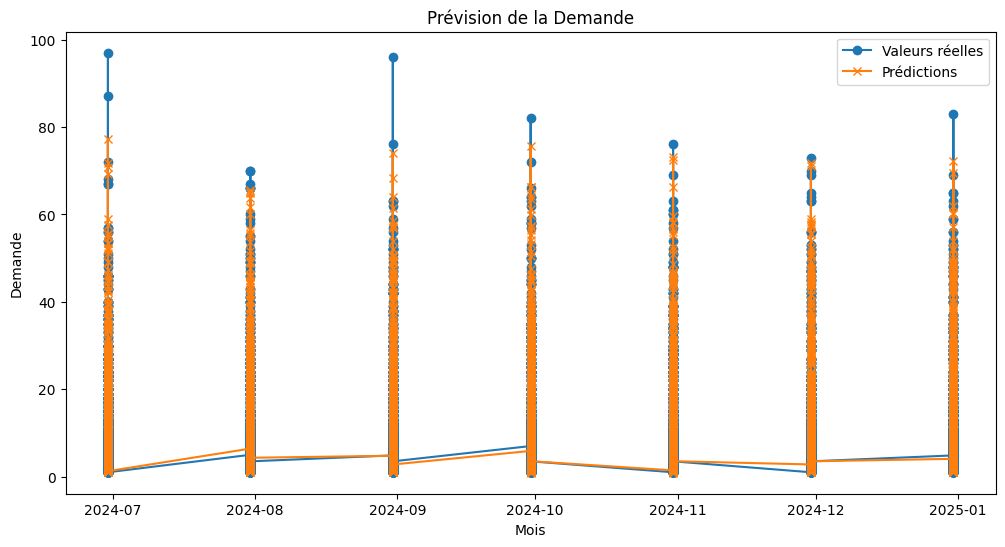

In [422]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# V√©rifier si le jeu de test est vide
if X_test.shape[0] == 0 or y_test.shape[0] == 0:
	print("Aucune donn√©e dans l'ensemble de test. Impossible d'√©valuer le mod√®le ou d'afficher les pr√©dictions.")
else:
	# Faire des pr√©dictions sur l'ensemble de test
	y_pred = model.predict(X_test)

	# √âvaluer les performances
	mae = mean_absolute_error(y_test, y_pred)
	rmse = np.sqrt(mean_squared_error(y_test, y_pred))
	mape = mean_absolute_percentage_error(y_test, y_pred)

	print(f"MAE : {mae:.2f}")
	print(f"RMSE : {rmse:.2f}")
	print(f"MAPE : {mape:.2f}")

	# Visualiser les r√©sultats
	plt.figure(figsize=(12, 6))
	plt.plot(test['Mois'], y_test, label='Valeurs r√©elles', marker='o')
	plt.plot(test['Mois'], y_pred, label='Pr√©dictions', marker='x')
	plt.xlabel('Mois')
	plt.ylabel('Demande')
	plt.title('Pr√©vision de la Demande')
	plt.legend()
	plt.show()

C:\Users\Franck\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 137 (\x89) missing from font(s) DejaVu Sans.

C:\Users\Franck\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128 (\x80) missing from font(s) DejaVu Sans.

C:\Users\Franck\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 153 (\x99) missing from font(s) DejaVu Sans.



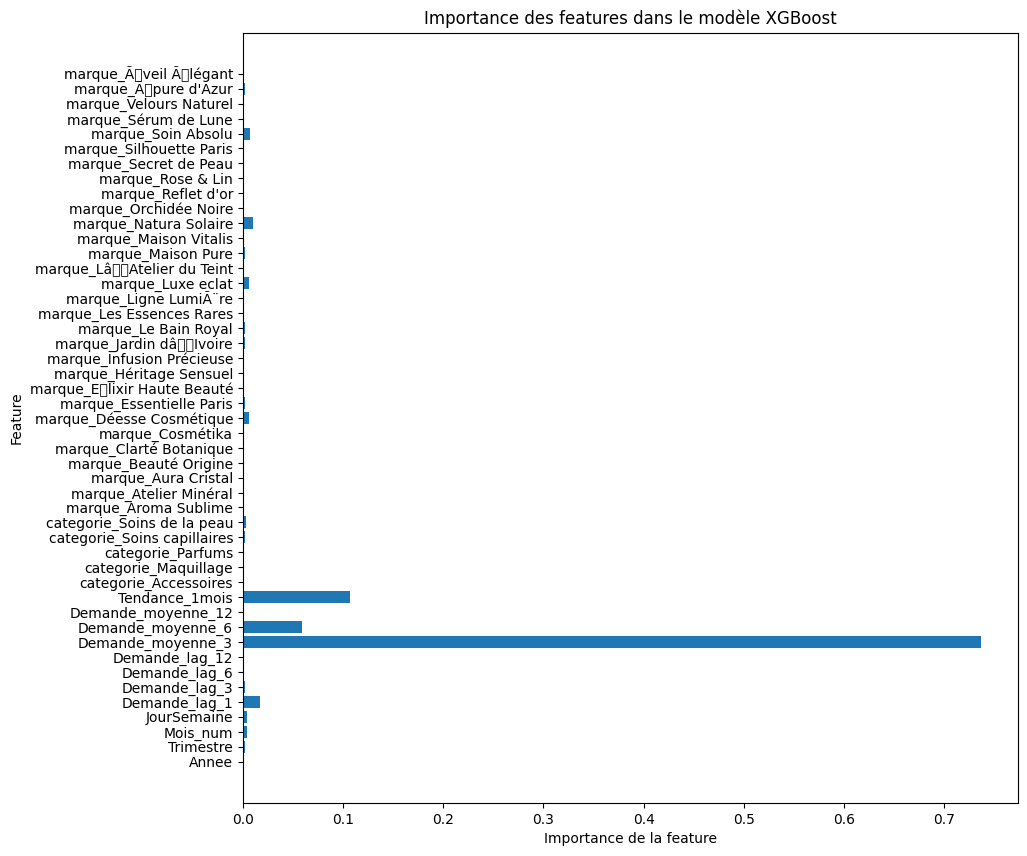

In [423]:
# Exemple d'analyse de l'importance des features (avec XGBoost)
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns, model.feature_importances_)
plt.xlabel('Importance de la feature')
plt.ylabel('Feature')
plt.title('Importance des features dans le mod√®le XGBoost')
plt.show()


# Estimation du d√©lai fournisseur

1. choix et pr√©paration des datasets pertinents

In [424]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Datasets
achats = dfs_cleaned['achats']
fournisseurs = dfs_cleaned['fournisseurs']
produits = dfs_cleaned['produits']

# 2. Fusion des datasets
df = achats.merge(fournisseurs, on='id_fournisseur', how='left')
df = df.merge(produits, on='id_produit', how='left')

2. Feature Engineering

In [425]:
df['date_achat'] = pd.to_datetime(df['date_achat'], errors='coerce')
df['annee'] = df['date_achat'].dt.year
df['mois'] = df['date_achat'].dt.month
df['jour_semaine'] = df['date_achat'].dt.dayofweek  # 0=Lundi

# Suppression des colonnes inutiles et traitement des valeurs manquantes
df = df.dropna(subset=['delai_livraison_jours'])

3.  S√©paration entra√Ænement / test

In [426]:
# Variables explicatives
features = ['annee', 'mois', 'jour_semaine', 'nom_fournisseur', 'ville', 'pays', 'categorie', 'marque', 'quantite']
target = 'delai_livraison_jours'


# S√©paration X / y
X = df[features]
y = df[target]

4. pr√©paration et entra√Ænement du mod√®le

In [427]:
# Pr√©paration pipeline de traitement
cat_features = ['nom_fournisseur', 'ville', 'pays', 'categorie', 'marque']
num_features = ['annee', 'mois', 'jour_semaine', 'quantite']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

model = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [428]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [429]:
# Entra√Ænement
model.fit(X_train, y_train)

# Pr√©diction & √©valuation
y_pred = model.predict(X_test)

print("Pr√©cision du mod√®le :")
print("MSE :", mean_squared_error(y_test, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R¬≤ Score :", r2_score(y_test, y_pred))

Pr√©cision du mod√®le :
MSE : 15.363666857267573
RMSE : 3.9196513693525823
MAE : 3.3249118095238095
R¬≤ Score : -0.0890162583018832


5. Visualisation

In [430]:
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import learning_curve

# Courbe d‚Äôapprentissage
def plot_learning_curve(model, X, y, title="Courbe d'apprentissage"):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_absolute_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Erreur d\'entra√Ænement'))
    fig.add_trace(go.Scatter(x=train_sizes, y=test_scores_mean, mode='lines+markers', name='Erreur de validation'))
    fig.update_layout(title=title,
                      xaxis_title='Taille de l\'√©chantillon d\'entra√Ænement',
                      yaxis_title='Erreur absolue moyenne (MAE)',
                      template='plotly_white')
    fig.show()

plot_learning_curve(model, X, y)


In [431]:
# R√©cup√©ration des noms apr√®s encodage
ohe = model.named_steps['prep'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_features)
all_features = list(cat_feature_names) + num_features

# Importance des variables
importances = model.named_steps['rf'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

fig = go.Figure(go.Bar(
    x=importances[sorted_idx],
    y=[all_features[i] for i in sorted_idx],
    orientation='h',
    marker_color='indianred'
))
fig.update_layout(title="Importance des variables",
                  xaxis_title="Importance",
                  yaxis_title="Variables",
                  template='plotly_white')
fig.show()


In [432]:
#prediction vs r√©el
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred,
                         mode='markers',
                         marker=dict(color='blue', opacity=0.5),
                         name='Pr√©dictions'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode='lines', name='Id√©al', line=dict(color='red')))
fig.update_layout(title='Pr√©dictions vs R√©el',
                  xaxis_title='D√©lai r√©el',
                  yaxis_title='D√©lai pr√©dit',
                  template='plotly_white')
fig.show()


In [433]:
#distribution des d√©lais (r√©el vs pr√©dit)
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_test, nbinsx=20, name='R√©el', opacity=0.6))
fig.add_trace(go.Histogram(x=y_pred, nbinsx=20, name='Pr√©dit', opacity=0.6))
fig.update_layout(barmode='overlay',
                  title='Distribution des d√©lais de livraison',
                  xaxis_title='D√©lai (jours)',
                  yaxis_title='Fr√©quence',
                  template='plotly_white')
fig.show()


# Analyse  de  probabilit√©  de  retour

1. selection et fusion des datasets pertinent

In [434]:
expeditions = dfs_cleaned['expeditions']
commandes = dfs_cleaned['commandes']
fournisseurs = dfs_cleaned['fournisseurs']
produits = dfs_cleaned['produits']
retours = dfs_cleaned['retours']

# Cr√©ation de la variable cible : retour ou non
retours["retour"] = 1
commandes_retour = commandes.merge(retours[['id_commande', 'id_produit', 'retour']],
                                   on=['id_commande', 'id_produit'], how='left')
commandes_retour["retour"] = commandes_retour["retour"].fillna(0)


In [435]:
# Fusion avec exp√©ditions
df = commandes_retour.merge(expeditions, on=['id_commande', 'id_produit'], how='left')

# Fusion avec produits
df = df.merge(produits, on='id_produit', how='left')

# Extraction de la saison √† partir de la date de commande
df['date_commande'] = pd.to_datetime(df['date_commande'])
df['mois'] = df['date_commande'].dt.month
df['saison'] = df['mois'].apply(lambda x: (
    'hiver' if x in [12,1,2] else
    'printemps' if x in [3,4,5] else
    '√©t√©' if x in [6,7,8] else
    'automne'))



In [436]:
# Ajout du d√©lai r√©el de livraison
df['date_expedition'] = pd.to_datetime(df['date_expedition'])
df['date_livraison'] = pd.to_datetime(df['date_livraison_x'])
df['delai_reel'] = (df['date_livraison'] - df['date_expedition']).dt.days

# Nettoyage/remplissage
df['transporteur'] = df['transporteur'].fillna('inconnu')
df['delai_reel'] = df['delai_reel'].fillna(df['delai_reel'].median())

def impute_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':  # Cat√©gorielles
            mode_value = df[column].mode()[0]
            df[column].fillna(mode_value, inplace=True)
        elif df[column].dtype in ['int64', 'float64']:  # Num√©riques
            if df[column].skew() > 1:  # Si la distribution est asym√©trique
                median_value = df[column].median()
                df[column].fillna(median_value, inplace=True)
            else:  # Si la distribution est sym√©trique
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)
    return df
# Imputation des valeurs manquantes
df = impute_missing_values(df)

df.head(5)

C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\3763686867.py:14: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\3763686867.py:18: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

id_commande date_commande id_produit  quantite_x entrepot_x   statut  \
0     O000001    2024-03-09     P00413           2  Marseille    Livr√©   
1     O000002    2024-09-11     P00778          15       Lyon  Exp√©di√©   
2     O000004    2024-03-11     P00535           8       Lyon    Livr√©   
3     O000006           NaT     P00898           3      Paris    Livr√©   
4     O000007           NaT     P00445           1       Lyon    Livr√©   

  date_livraison_x  delai_traitement  prix_total_ligne  retour  ...  \
0       2024-09-15        190.000000            302.68     0.0  ...   
1       2024-11-23         73.000000           6512.10     0.0  ...   
2       2024-11-09        243.000000           2292.56     0.0  ...   
3       2024-01-28         47.735233            270.78     0.0  ...   
4       2024-02-21         47.735233            436.94     0.0  ...   

  cout_transport  delai_livraison         categorie                marque  \
0          11.62                6       Accessoires     Essentielle Paris   
1          13.61                7       Accessoires      Silhouette Paris   
2          19.32                3        Maquillage           Soin Absolu   
3          14.79                2  Soins de la peau       Velours Naturel   
4          13.56                3       Accessoires  E¬âlixir Haute Beaut√©   

     prix stock_minimum      mois     saison date_livraison delai_reel  
0  151.34            50  3.000000  printemps     2024-09-15        6.0  
1  434.14            91  9.000000    automne     2024-11-23       32.0  
2  286.57            66  3.000000  printemps     2024-11-09      151.0  
3   90.26            56  6.476373    automne     2024-01-28       32.0  
4  436.94            21  6.476373    automne     2024-02-21       32.0  

[5 rows x 26 columns]

2. Pr√©paration des features

In [437]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# S√©lection des features pertinentes
features = ['categorie', 'marque', 'transporteur', 'quantite_x', 'prix', 'delai_reel', 'saison']
X = df[features]
y = df['retour']

# Encodage des variables cat√©gorielles
cat_cols = ['categorie', 'marque', 'transporteur', 'saison']
num_cols = ['quantite', 'prix', 'delai_reel']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# Pipeline de classification
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Entra√Ænement
pipeline.fit(X_train, y_train)

# Pr√©diction
y_pred = pipeline.predict(X_test)


3. Visualisation et √©valuation

In [438]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

# R√©partition des retours
fig1 = px.pie(df, names='retour', title='R√©partition des retours (1 = retour, 0 = non-retour)')
fig1.show()

# Taux de retour par transporteur
fig2 = px.bar(df.groupby('transporteur')['retour'].mean().reset_index(),
              x='transporteur', y='retour', title='Taux de retour par transporteur')
fig2.show()

# Taux de retour par saison
fig3 = px.bar(df.groupby('saison')['retour'].mean().reset_index(),
              x='saison', y='retour', title='Taux de retour par saison')
fig3.show()


print("Rapport de classification :")
print(classification_report(y_test, y_pred))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      7895
         1.0       0.73      0.59      0.65       597

    accuracy                           0.96      8492
   macro avg       0.85      0.79      0.82      8492
weighted avg       0.95      0.96      0.95      8492

Matrice de confusion :
[[7761  134]
 [ 242  355]]
